In [2]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv
from joblib import Parallel, delayed

# BPM Data

In [8]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [9]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.08086005371776343


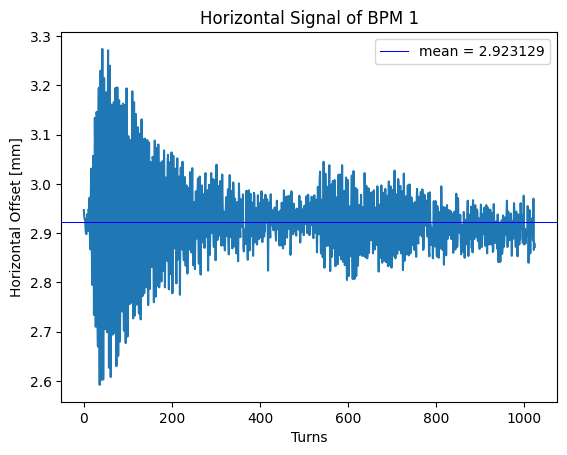

Standard deviation of First Vertical BPM = 0.14039846131415454


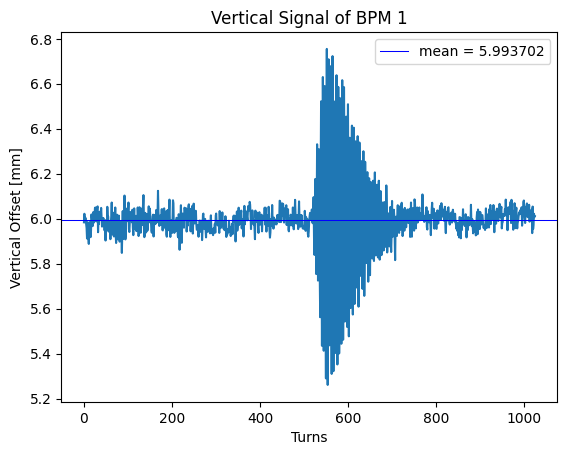

In [303]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

0.23483365949119372


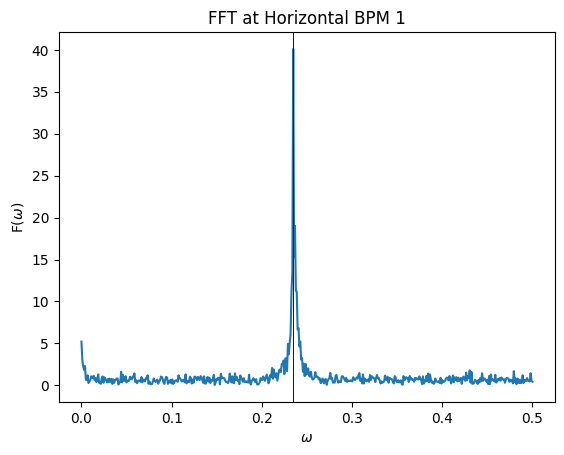

0.22896281800391388


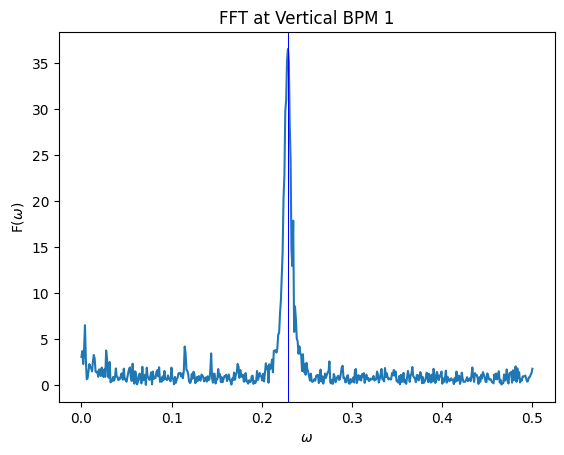

In [11]:
# Look at First BPM FFTs
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


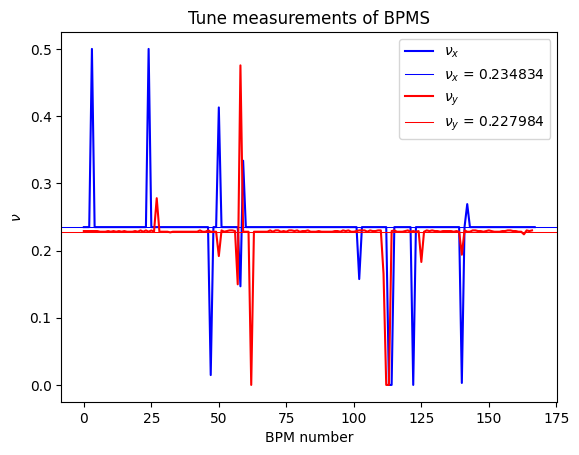

In [12]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [13]:
# Collect bad BPMs
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM

[11.1800003  -7.84100008]
[10.6379995  -7.34000015]
[2547.88696 2563.90674]
[0. 0. 0. ... 0. 0. 0.]


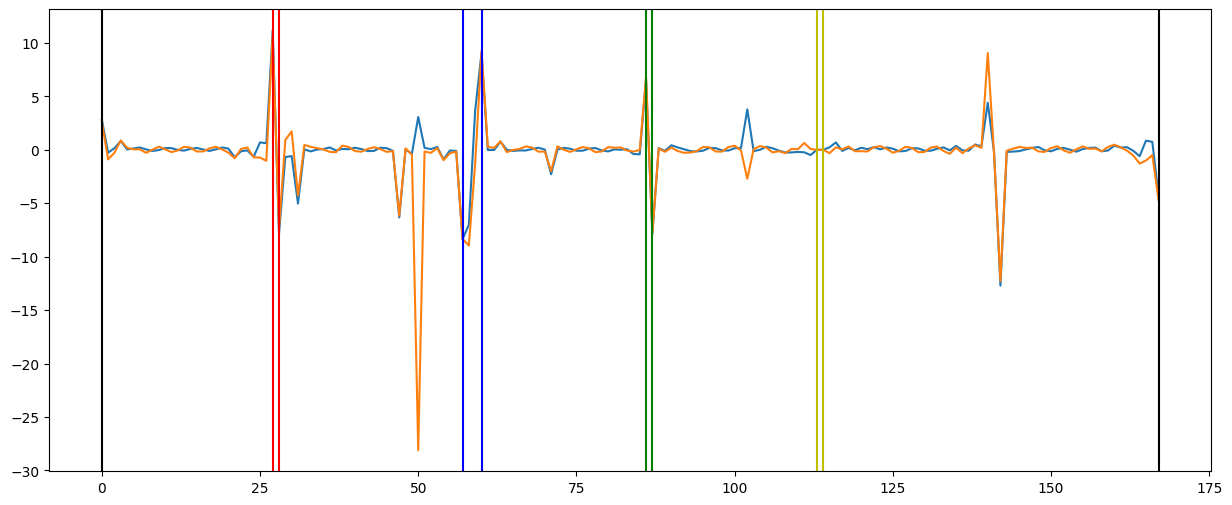

In [14]:
fig, Ax = plt.subplots(figsize = (15, 6))
Ax.plot(Pos_xbpms[35, :])
Ax.plot(Pos_xbpms[36, :])
print(Pos_xbpms[35, 27:29])
print(Pos_xbpms[36, 27:29])
print(S_xbpms[0, 113: 115])
print(BPMx[113])

#IP6
Ax.axvline(x = 0, color = 'k')
Ax.axvline(x = 167, color = 'k')

#IP8
Ax.axvline(x = 27, color = 'r')
Ax.axvline(x = 28, color = 'r')

#IP10
Ax.axvline(x = 57, color = 'b')
Ax.axvline(x = 60, color = 'b')

#IP12
Ax.axvline(x = 86, color = 'g')
Ax.axvline(x = 87, color = 'g')

#IP2
Ax.axvline(x = 113, color = 'y')
Ax.axvline(x = 114, color = 'y')
plt.show()

## Phase Transfer Matrix Calculation

In [16]:
# s points
C = 3834 #m

# IP6
s_167, s_0 = S_xbpms[0, 167] - C, S_xbpms[0, 0]
sIP6 = 0
L_167_0 = s_0 - s_167
print(s_167, s_0, L_167_0)

# IP8
s_27, s_28 = S_xbpms[0, 27: 29]
sIP8 = 639.445027949618
L_27_28 = s_28 - s_27
print(s_27, s_28, L_27_28)

# IP10
s_57, s_60 = S_xbpms[0, 57], S_xbpms[0, 60]
sIP10 = 1277.94839381844
L_57_60 = s_60 - s_57
print(s_57, s_60, L_57_60)

# IP12
s_86, s_87 = S_xbpms[0, 86: 88]
sIP12 = 1917.39342276804
L_86_87 = s_87 - s_86
print(s_86, s_87, L_86_87)

# IP2
s_113, s_114 = S_xbpms[0, 113: 115]
sIP2 = 2555.89678863688
L_113_114 = s_114 - s_113
print(s_113, s_114, L_113_114)

# IP4
# s_113, s_114 = S_xbpms[0, 113: 115]
# sIP2 = 2555.89678863688
# L_113_114 = s_114 - s_113
# print(s_113, s_114, L_113_114)

# sIP2 = 2555.89678863688
#         sIP4 = 3195.34181658652


-8.481200000000172 7.99309015 16.474290150000172
631.118713 647.771362 16.652648999999997
1269.62207 1286.27478 16.65271000000007
1909.06702 1925.71985 16.652829999999994
2547.88696 2563.90674 16.019780000000083


[10.7130003 10.5939999]
-0.24089132519531198 -0.3598917251953111 0.028164032438974643 0.041615371021803085


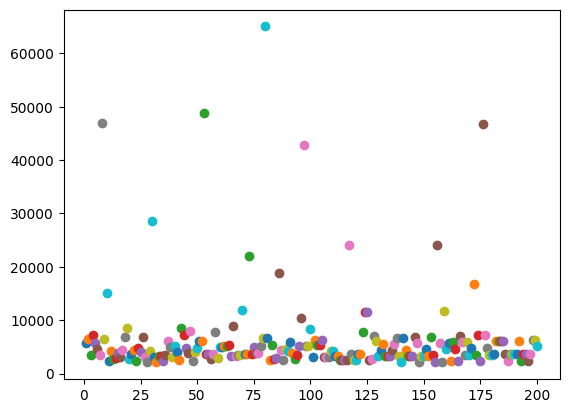

6300.147260105579


In [17]:
phi = 2*np.pi*nu_x
m_mm = 10**3 # meters to millimeters


def x_final(x, xp, b, a):
    return (np.cos(phi) + a*np.sin(phi))*x + b*np.sin(phi)*xp

def xp_final(x, xp, b, a):
    g = (1 + a**2)/b
    return -g*np.sin(phi)*x + (np.cos(phi) - a*np.sin(phi))*xp

def eps_bpm(x, xp, b, a):
    g = (1 + a**2)/b
    return g*x**2 + 2*a*x*xp + b*xp**2


#if i use jac, result becomes too close to guess, if not result goes far from guess
# def jac_func(x, args):
#     b, a, phi = x
#     xi, xf, xpi, xpf = args
#     Jac = [
#         [np.sin(phi)*xpi, np.sin(phi)*xi],
#         [(1 + a**2)/b**2*np.sin(phi)*xi, -2*a/b*np.sin(phi)*xi - np.sin(phi)*xpi]
#     ]
#     return Jac

def func(x, args):
    b, a = x
    xi, xf, xpi, xpf = args
    g = (1 + a**2)/b
    System = [
            #Phase Transfer from current turn to next turn
            xf - x_final(xi, xpi, b, a),
            xpf - xp_final(xi, xpi, b, a)]
    
#     print(b, a, System)
#     Sys_vals.append([xs, xps, bs, ss, b0, b, a0, a])
    return System


turn = 40
# x positions at BPM 27
xi_27, xf_27 = BPMx[27, turn: turn + 2] - np.mean(BPMx[27])
print(BPMx[27, turn: turn + 2])

# x positions at BPM 28
xi_28, xf_28 = BPMx[28, turn: turn + 2] - np.mean(BPMx[28])

# x speed at BPM 27/28 for current turn
xpi_27 = xpi_28 = (xi_28 - xi_27)/L_27_28

# x speed at BPM 27/28 at next turn
xpf_27 = xpf_28 = (xf_28 - xf_27)/L_27_28

# 99.54348468, 99.62958574, 11.87358459, -11.87875497
print(xi_27, xf_27, xpi_27, xpf_27)
Init_var_27 = [100, 12]

Args_27 = [[xi_27, xf_27, xpi_27, xpf_27]]
Bounds_27 = (0, np.inf)
# print(optimize.least_squares(func, Init_var_27, bounds = Bounds_27, args = Args_27))
# print(optimize.least_squares(func, Init_var_27, jac = jac_func, bounds = Bounds_27, args = Args_27))
Result_b = np.zeros(200)
for i in range(0, 200):
    Init_var_27 = [i + 1, 12]
    Result27 = optimize.least_squares(func, Init_var_27, bounds = Bounds_27, args = Args_27)
    plt.plot(i + 1, Result27['x'][0], 'o')
    Result_b[i] = Result27['x'][0]
plt.show()

print(np.mean(Result_b))
# Init_var_28 = [100, -12]
# Args_28 = [[xi_28, xf_28, xpi_28, xpf_28]]
# Bounds_28 = ([0, -np.inf], [np.inf, 0])
# print(optimize.least_squares(func, Init_var_28, jac = jac_func, bounds = Bounds_28, args = Args_28))
# print(optimize.least_squares(func, Init_var_28, bounds = Bounds_28, args = Args_28))


## Linear Regression Calculation

In [18]:
#Linear Regression
from sklearn.linear_model import LinearRegression

In [312]:
def LR_calculation(initial_turn, interval_turn, bpm1, bpm2, s1, s2, L):
    #Organize position and speed data
    # Scaled position and speed between two bpms
    x_data1_all = BPMx[bpm1] - np.mean(BPMx[bpm1])
    x_data2_all = BPMx[bpm2] - np.mean(BPMx[bpm2])
    xp_data_all = (x_data2_all - x_data1_all)/L
    
    # X Train data
    x_data1 = x_data1_all[initial_turn: initial_turn + interval_turn]
    x_data2 = x_data2_all[initial_turn: initial_turn + interval_turn]
    xp_data = xp_data_all[initial_turn: initial_turn + interval_turn]

    X_data1 = np.array(list(zip(x_data1, xp_data)))
    X_data2 = np.array(list(zip(x_data2, xp_data)))
    
    # Y Train data
    y_data1 = x_data1_all[initial_turn + 1: initial_turn + interval_turn + 1]
    y_data2 = x_data2_all[initial_turn + 1: initial_turn + interval_turn + 1]
    yp_data = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]
    
    Y_data1 = np.array(list(zip(y_data1, yp_data)))
    Y_data2 = np.array(list(zip(y_data2, yp_data)))
    
    #LR Calculation:
    result1 = LinearRegression().fit(X_data1, Y_data1)
    result2 = LinearRegression().fit(X_data2, Y_data2)

    #Correlation:
    corr1 = result1.score(X_data1, Y_data1)
    corr2 = result2.score(X_data2, Y_data2)
    print("Correlation from first bpm:", corr1)
    print("Correlation from second bpm:", corr2)
    print()
    
    #Prediction:
    pred1 = result1.predict(X_data1)
    pred2 = result2.predict(X_data2)
    plt.scatter(pred1, Y_data1)
    plt.title("prediction vs real for bpm %d"%bpm1)
    plt.xlabel("predicted next turn values")
    plt.ylabel("Actual next turn values")
    plt.show()
    print()
    plt.scatter(pred2, Y_data2)
    plt.title("prediction vs real for bpm %d"%bpm2)
    plt.xlabel("predicted next turn values")
    plt.ylabel("Actual next turn values")
    plt.show()
    print()
    
    def Twiss_calculation(bpm, result):
        M = result.coef_
        m11, m12 = M[0]
        m21, m22 = M[1]
        B = result.intercept_
        b1, b2 = B
        det = m11*m22 - m12*m21
        print("determinant:", det)
        m11 /= np.sqrt(det)
        m12 /= np.sqrt(det)
        m21 /= np.sqrt(det)
        m22 /= np.sqrt(det)
        print(m11*m22 - m12*m21)
        

        print("Matrix Elements from bpm %d: "%bpm, m11, m12, m21, m22)
        print("y-intercepts from bpm %d: "%bpm, b1, b2)

        #Twiss at first bpm
        print("Twiss parameter calculation from bpm %d:"%bpm)
        phi = np.arccos((m11 + m22)/2)
        beta = m12/np.sin(phi)
        alpha = (m11 - m22)/(2*np.sin(phi))
        print("\t -gs/b vs m21:", -(1 + alpha**2)/beta*np.sin(phi), m21)
        print("\t c - as vs m22:", np.cos(phi) - alpha*np.sin(phi), m22)
        print()
        print("tune:", phi/(2*np.pi))
        
        return np.array([phi, beta, alpha])
    
    Twiss1 = Twiss_calculation(bpm1, result1)
    Twiss2 = Twiss_calculation(bpm2, result2)
    
    #Calculation of beta*/s* using beta and alpha
    phi1, beta1, alpha1 = Twiss1
    phi2, beta2, alpha2 = Twiss2
    bs1 = beta1/(1 + alpha1**2)
    bs2 = beta2/(1 + alpha2**2)
    ss1 = s1 + bs1*alpha1
    ss2 = s2 + bs2*alpha2
    Twiss1 = np.append(Twiss1, [bs1, ss1])
    Twiss2 = np.append(Twiss2, [bs2, ss2])
    
    return Twiss1, Twiss2, X_data1, Y_data1, X_data2, Y_data2

def plot_correlations(X_data1, Y_data1, X_data2, Y_data2, bpm1, bpm2):
    fig, Ax = plt.subplots(2, 3, figsize=(18, 8))
    Ax[0][0].plot(X_data1.T[0], X_data1.T[1], 'o')
    Ax[0][1].plot(X_data1.T[0], Y_data1.T[0], 'o')
    Ax[0][2].plot(X_data1.T[1], Y_data1.T[0], 'o')
    Ax[1][0].plot(X_data2.T[0], X_data2.T[1], 'o')
    Ax[1][1].plot(X_data2.T[0], Y_data2.T[1], 'o')
    Ax[1][2].plot(X_data2.T[1], Y_data2.T[1], 'o')
    fig.suptitle("Correlations between bpm %d and %d"%(bpm1, bpm2))
    Ax[0][0].set_xlabel('x of Current turn for bpm %d'%bpm1)
    Ax[0][0].set_ylabel('xp of Current turn for bpm %d'%bpm1)
    Ax[0][1].set_xlabel('x of Current turn for bpm %d'%bpm1)
    Ax[0][1].set_ylabel('x of Next turn for bpm %d'%bpm1)
    Ax[0][2].set_xlabel('xp of Current turn for bpm %d'%bpm1)
    Ax[0][2].set_ylabel('x of Next turn for bpm %d'%bpm1)

    Ax[1][0].set_xlabel('x of Current turn for bpm%d'%bpm2)
    Ax[1][0].set_ylabel('xp of Current turn for bpm %d'%bpm2)
    Ax[1][1].set_xlabel('x of Current turn for bpm %d'%bpm2)
    Ax[1][1].set_ylabel('x of Next turn for bpm %d'%bpm2)
    Ax[1][2].set_xlabel('xp of Current turn for bpm %d'%bpm2)
    Ax[1][2].set_ylabel('x of Next turn for bpm %d'%bpm2)
    plt.show()

### IP6 (BPM 167-0)

Correlation from first bpm: 0.9791959811019693
Correlation from second bpm: 0.981647614167733



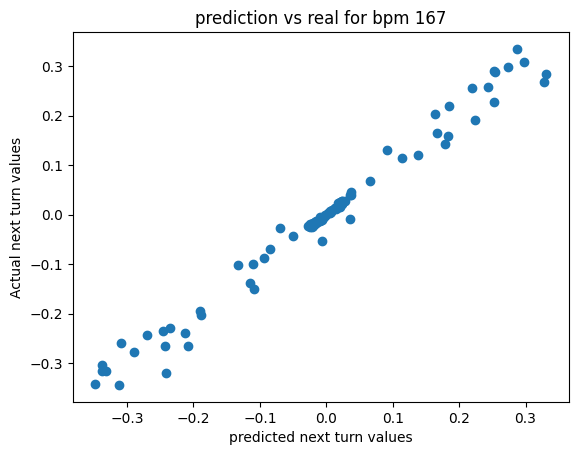

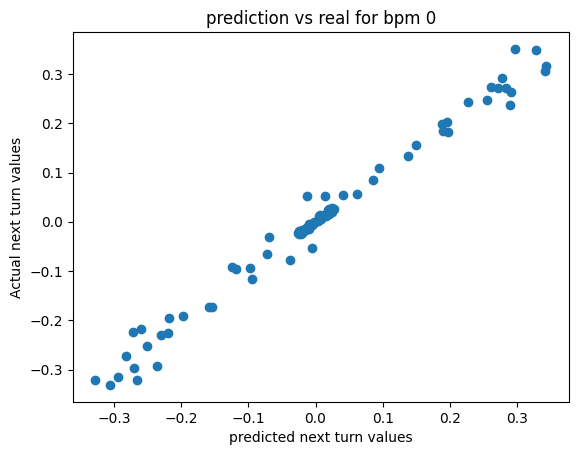


determinant: 0.9746229438270037
0.9999999999999999
Matrix Elements from bpm 167:  1.0062843133696588 16.614371178738537 -0.11054075687862873 -0.8313407593117478
y-intercepts from bpm 167:  -0.018066053741906764 0.0009548462335339466
Twiss parameter calculation from bpm 167:
	 -gs/b vs m21: -0.11054075687862874 -0.11054075687862873
	 c - as vs m22: -0.8313407593117479 -0.8313407593117478

tune: 0.23606061985972063
determinant: 0.9746229438270043
1.0
Matrix Elements from bpm 0:  -0.8147961888494981 16.34181112453631 -0.11054075687862877 0.9897397429074093
y-intercepts from bpm 0:  -0.002335639842033696 0.0009548462335339474
Twiss parameter calculation from bpm 0:
	 -gs/b vs m21: -0.11054075687862877 -0.11054075687862877
	 c - as vs m22: 0.9897397429074094 0.9897397429074093

tune: 0.2360606198597206


In [313]:
initial_turn = 30
interval_turn = 50
bpm1, bpm2 = 167, 0
L = L_167_0
Twiss1, Twiss2, X_data1, Y_data1, X_data2, Y_data2 = LR_calculation(initial_turn, interval_turn, bpm1, bpm2, s_167, s_0, L)

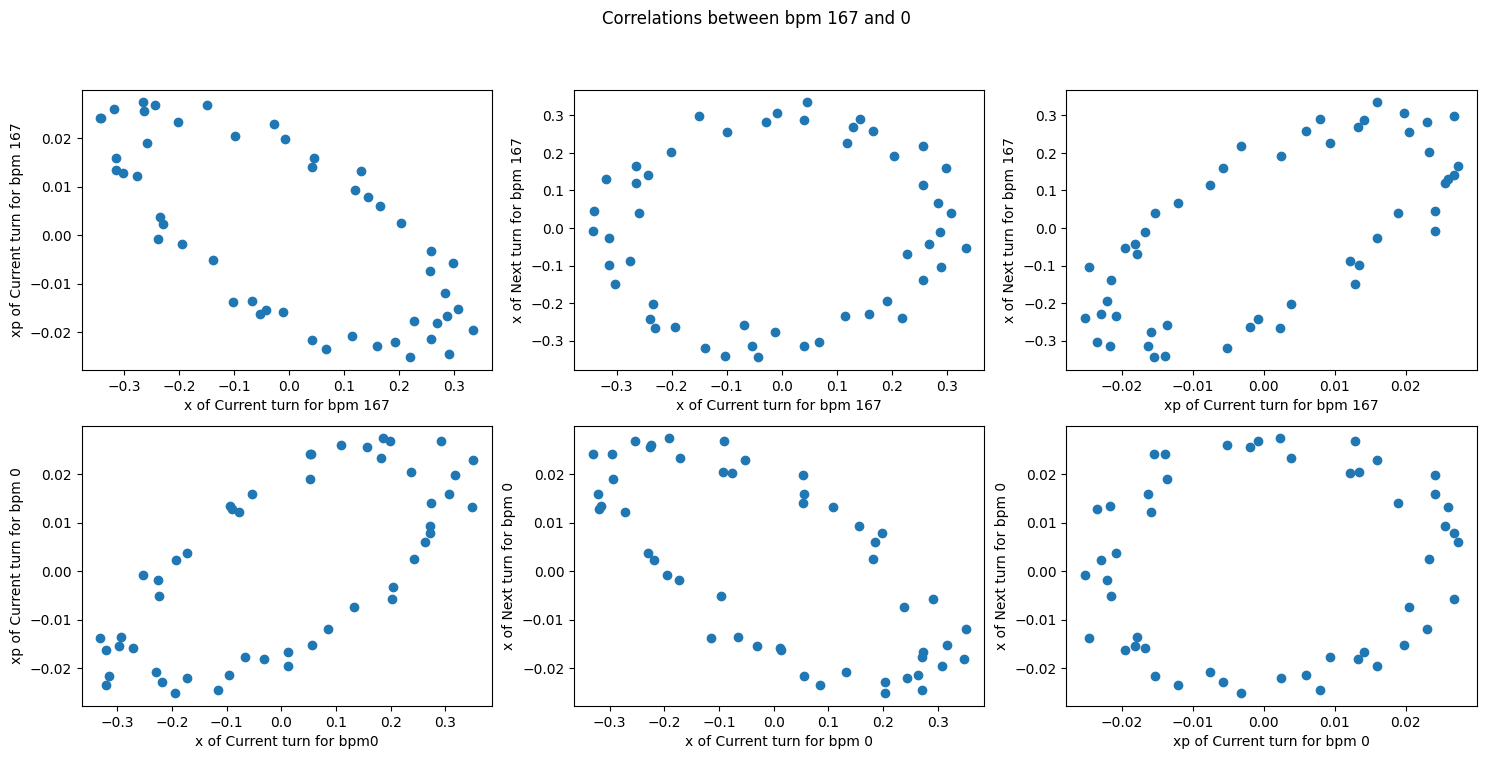

In [314]:
plot_correlations(X_data1, Y_data1, X_data2, Y_data2, bpm1, bpm2)

In [315]:
phi1, beta1, alpha1, bs1, ss1 = Twiss1
phi2, beta2, alpha2, bs2, ss2 = Twiss2
b1_m = 100.3380643
bs_m = 0.6958493096
b2_m = 92.50155563

print("phi, beta, alpha from LR at bpm 167:", phi1, beta1, alpha1)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 167:", bs1, ss1, ss1 - sIP6)
print("phi, beta, alpha from MADx at bpm 167:", 27.99282821, b1_m, 11.9664182)
print("beta beat at bpm 167:", (b1_m - beta1)/b1_m)
print("beta beat at b* from bpm 167:", (bs_m - bs1)/bs_m)
print()
print("phi, beta, alpha from LR at bpm 0:", phi2, beta2, alpha2)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 0:", bs2, ss2, ss2 - sIP6)
print("phi, beta, alpha from MADx at bpm 0:", 0.2362810226, 92.50155563, -11.48622524)
print("beta beat at bpm 0:", (b2_m - beta2)/b2_m)
print("beta beat at b* from bpm 0:", (bs_m - bs2)/bs_m)
print()
bs_2, ss_2 = L_167_0/(alpha1 - alpha2), s_0 + L_167_0*alpha1/(alpha1 - alpha2)
print("beta*, s*, and delta s* calculated from both bpms:", bs_2, ss_2, ss_2 - sIP6)
print("beta beat at b* from both bpms:", (bs_m - bs_2)/bs_m)

phi, beta, alpha from LR at bpm 167: 1.4832126183063024 16.67829912998942 0.922347897528917
beta*, s*, and delta s* calculated from beta and alpha at bpm 167: 9.01176205310332 -0.16922021728944792 -0.16922021728944792
phi, beta, alpha from MADx at bpm 167: 27.99282821 100.3380643 11.9664182
beta beat at bpm 167: 0.8337789427537381
beta beat at b* from bpm 167: -11.950737938194715

phi, beta, alpha from LR at bpm 0: 1.4832126183063021 16.404690332764027 -0.9057396676911424
beta*, s*, and delta s* calculated from beta and alpha at bpm 0: 9.011762053103316 -0.16922021728944525 -0.16922021728944525
phi, beta, alpha from MADx at bpm 0: 0.2362810226 92.50155563 -11.48622524
beta beat at bpm 0: 0.8226549789240121
beta beat at b* from bpm 0: -11.95073793819471

beta*, s*, and delta s* calculated from both bpms: 9.01176205310332 16.305069932710722 16.305069932710722
beta beat at b* from both bpms: -11.950737938194715


- Correlation very high, yet beta beat is very high
    - therefore not a good indicator of successful beta values
    - LR able to predict
- beta values for each bpm are very close to m12 since beta = m12/sin(phi)
- alpha have correct signs
- Beta and Alpha for each bpm off by some factor different from each other
    - results agree with Averages method

### IP8 (BPM 27-28)

Correlation from first bpm: 0.288435839021948
Correlation from second bpm: 0.27261595425696517



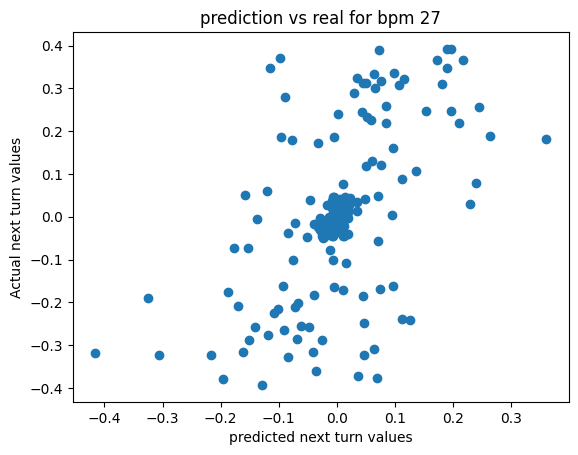

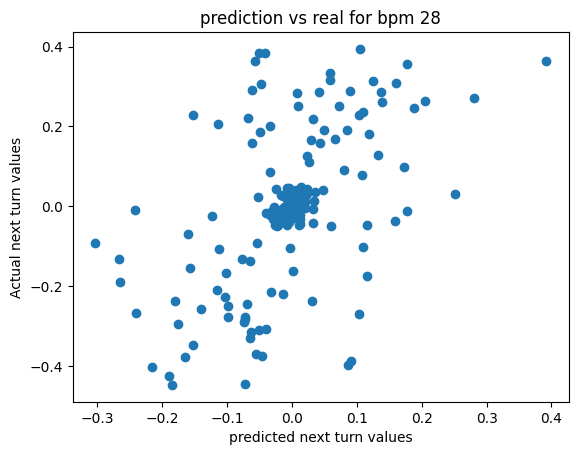


determinant: 0.30619031970125477
determinant after: 1.0

Matrix Elements from bpm 27:  9.482423319956855 78.33126633163644 -1.09014072741241 -8.899845620717274
y-intercepts from bpm 27:  0.008157364812464657 -0.0009958023693143517
Twiss parameter calculation from bpm 27:
	 -gs/b vs m21: -1.0196165469712586 -1.09014072741241
	 c - as vs m22: -8.317267921477693 -8.899845620717274

tune: 0.15102208539289635
determinant: 0.30619031970124766
determinant after: 1.0000000000000142

Matrix Elements from bpm 28:  -8.67130757424679 74.52550246061692 -1.0901407274124235 9.25388527348638
y-intercepts from bpm 28:  -0.008425382517095582 -0.0009958023693143474
Twiss parameter calculation from bpm 28:
	 -gs/b vs m21: -1.1579257171033432 -1.0901407274124235
	 c - as vs m22: 9.836462972725972 9.25388527348638

tune: 0.15102208539289425


In [299]:
initial_turn = 30
interval_turn = 100
bpm1, bpm2 = 27, 28
L = L_27_28
Twiss1, Twiss2, X_data1, Y_data1, X_data2, Y_data2 = LR_calculation(initial_turn, interval_turn, bpm1, bpm2, s_27, s_28, L)

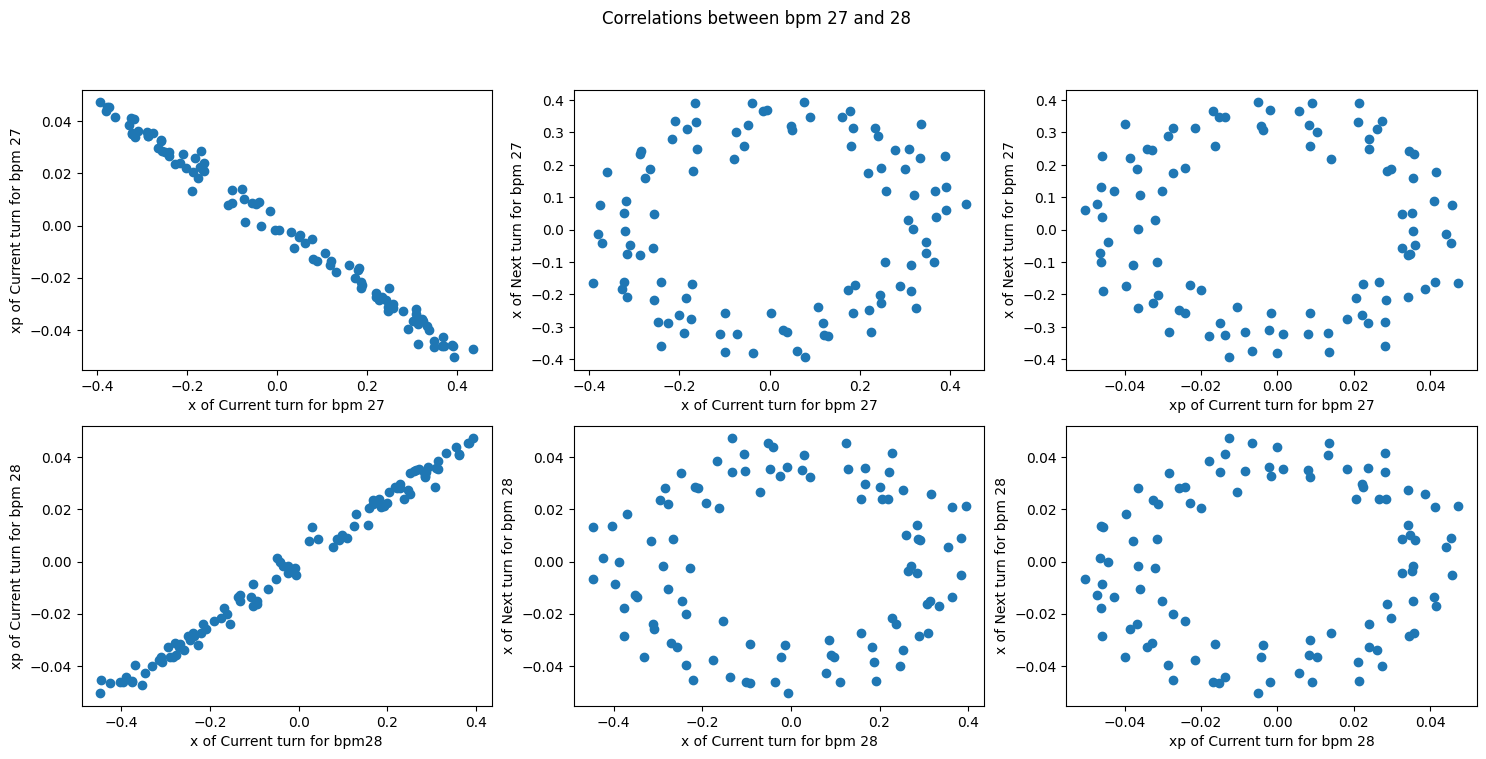

In [300]:
plot_correlations(X_data1, Y_data1, X_data2, Y_data2, bpm1, bpm2)

In [301]:
phi1, beta1, alpha1, bs1, ss1 = Twiss1
phi2, beta2, alpha2, bs2, ss2 = Twiss2
b1_m = 99.54348468
bs_m = 0.7011039589
b2_m = 99.62958574

print("phi, beta, alpha from LR at bpm 27:", phi1, beta1, alpha1)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 27:", bs1, ss1, ss1 - sIP8)
print("phi, beta, alpha from MADx at bpm 27:", 5.055131579, b1_m, 11.87358459)
print("beta beat at bpm 27:", (b1_m - beta1)/b1_m)
print("beta beat at b* from bpm 27:", (bs_m - bs1)/bs_m)
print()
print("phi, beta, alpha from LR at bpm 28:", phi2, beta2, alpha2)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 28:", bs2, ss2, ss2 - sIP8)
print("phi, beta, alpha from MADx at bpm 28:", 5.52839225, b2_m, -11.87875497)
print("beta beat at bpm 28:", (b2_m - beta2)/b2_m)
print("beta beat at b* from bpm 0:", (bs_m - bs2)/bs_m)
print()
bs_2, ss_2 = L_27_28/(alpha1 - alpha2), s_27 + L_27_28*alpha1/(alpha1 - alpha2)
print("beta*, s*, and delta s* calculated from both bpms", bs_2, ss_2, ss_2 - sIP8)
print("beta beat at b* from bothbpms:", (bs_m - bs_2)/bs_m)

phi, beta, alpha from LR at bpm 27: 0.9488997480002671 96.37509141535145 10.949949815029674
beta*, s*, and delta s* calculated from beta and alpha at bpm 27: 0.7971379211220092 639.847333231943 0.4023052823250737
phi, beta, alpha from MADx at bpm 27: 5.055131579 99.54348468 11.87358459
beta beat at bpm 27: 0.03182923799416821
beta beat at b* from bpm 27: -0.13697535294577726

phi, beta, alpha from LR at bpm 28: 0.948899748000254 91.69265925062919 -11.385543486601785
beta*, s*, and delta s* calculated from beta and alpha at bpm 28: 0.7019232776239686 639.7795839983542 0.3345560487362036
phi, beta, alpha from MADx at bpm 28: 5.52839225 99.62958574 -11.87875497
beta beat at bpm 28: 0.07966435301742132
beta beat at b* from bpm 0: -0.0011686123199960796

beta*, s*, and delta s* calculated from both bpms 0.7455688923057558 639.2826549543953 -0.16237299522265403
beta beat at b* from bothbpms: -0.06342131269023113


### IP10 (BPM 57-60)

Correlation from first bpm: 0.8567655459561154
Correlation from second bpm: 0.8860321467460637



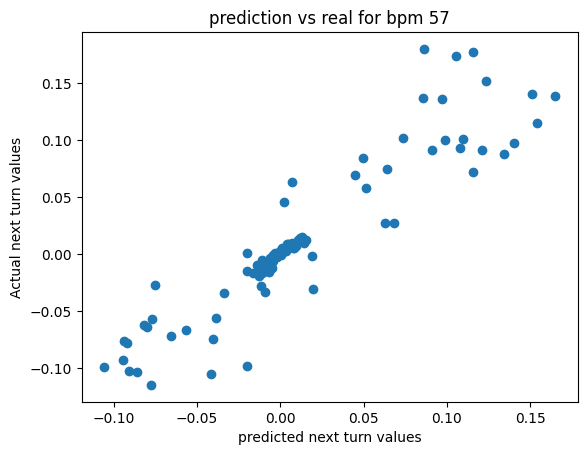

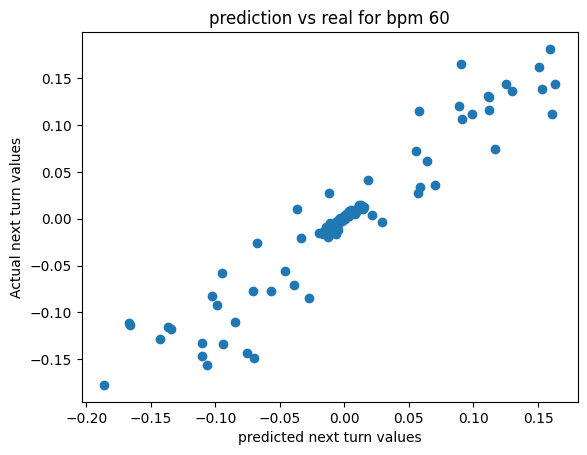


determinant: 0.8585622459367055
determinant after: 1.0

Matrix Elements from bpm 57:  1.3335935836763013 14.719026439242334 -0.17380864273809338 -1.1684924304562798
y-intercepts from bpm 57:  0.013564094594093615 0.0006710392384638073
Twiss parameter calculation from bpm 57:
	 -gs/b vs m21: -0.1588499197885399 -0.17380864273809338
	 c - as vs m22: -1.0033912772362583 -1.1684924304562798

tune: 0.2236024702411293
determinant: 0.8585622459367048
determinant after: 1.0000000000000004

Matrix Elements from bpm 60:  -1.5607913393347863 21.251866402112555 -0.17380864273809343 1.7258924925548083
y-intercepts from bpm 60:  0.024738716430852275 0.0006710392384638064
Twiss parameter calculation from bpm 60:
	 -gs/b vs m21: -0.18593409304839556 -0.17380864273809343
	 c - as vs m22: 1.8909936457748302 1.7258924925548083

tune: 0.22360247024112923


In [293]:
initial_turn = 35
interval_turn = 50
bpm1, bpm2 = 57, 60
L = L_57_60
Twiss1, Twiss2, X_data1, Y_data1, X_data2, Y_data2 = LR_calculation(initial_turn, interval_turn, bpm1, bpm2, s_57, s_60, L)

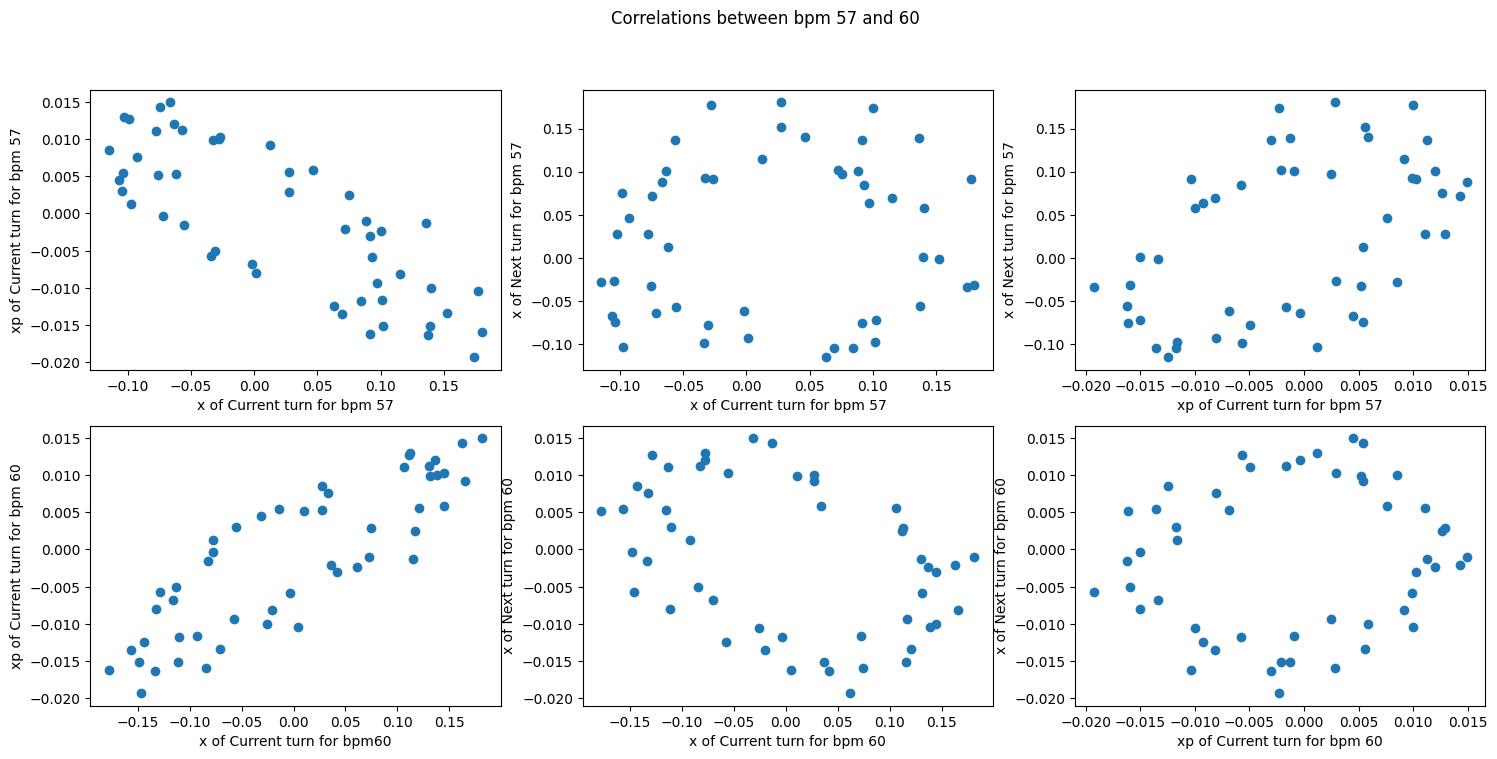

In [294]:
plot_correlations(X_data1, Y_data1, X_data2, Y_data2, bpm1, bpm2)

In [295]:
phi1, beta1, alpha1, bs1, ss1 = Twiss1
phi2, beta2, alpha2, bs2, ss2 = Twiss2
b1_m = 18.85271553
bs_m = 5.059938613
b2_m = 18.67088168

print("phi, beta, alpha from LR at bpm 57:", phi1, beta1, alpha1)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 57", bs1, ss1, ss1 - sIP10)
print("phi, beta, alpha from MADx at bpm 57:", 9.291939091, b1_m, 1.651057046)
print("beta beat at bpm 57:", (b1_m - beta1)/b1_m)
print("beta beat at b* from bpm 57:", (bs_m - bs1)/bs_m)
print()
print("phi, beta, alpha from LR at bpm 60:", phi2, beta2, alpha2)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 60", bs2, ss2, ss2 - sIP10)
print("phi, beta, alpha from MADx at bpm 60:", 9.61812519, b2_m, -1.640137896)
print("beta beat at bpm 60:", (b2_m - beta2)/b2_m)
print("beta beat at b* from bpm 60:", (bs_m - bs2)/bs_m)
print()
bs_2, ss_2 = L_57_60/(alpha1 - alpha2), s_57 + L_57_60*alpha1/(alpha1 - alpha2)
print("beta*, s*, and delta s* calculated from both bpms", bs_2, ss_2, ss_2 - sIP10)
print("beta beat at b* from both bpms:", (bs_m - bs_2)/bs_m)

phi, beta, alpha from LR at bpm 57: 1.4049357556681243 14.92383156298489 1.1847511985072567
beta*, s*, and delta s* calculated from beta and alpha at bpm 57 6.208858277051828 1276.9780222850989 -0.970371533341222
phi, beta, alpha from MADx at bpm 57: 9.291939091 18.85271553 1.651057046
beta beat at bpm 57: 0.20839883574136284
beta beat at b* from bpm 57: -0.2270619768192488

phi, beta, alpha from LR at bpm 60: 1.404935755668124 21.547571498248587 -1.7499070988851324
beta*, s*, and delta s* calculated from beta and alpha at bpm 60 5.304442144622629 1276.9924990354993 -0.9558947829407316
phi, beta, alpha from MADx at bpm 60: 9.61812519 18.67088168 -1.640137896
beta beat at bpm 60: -0.15407359264292578
beta beat at b* from bpm 60: -0.04832144227885505

beta*, s*, and delta s* calculated from both bpms 5.674497100666524 1276.3449372409405 -1.603456577499628
beta beat at b* from both bpms: -0.12145572005312465


### IP12 (BPM 86-87)

Correlation from first bpm: 0.7744451440274998
Correlation from second bpm: 0.7977305184297507



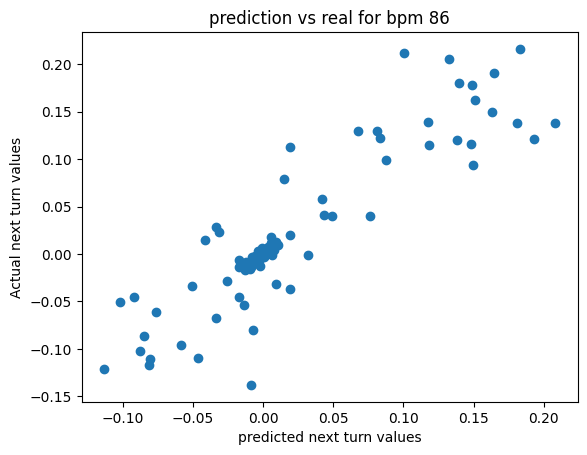

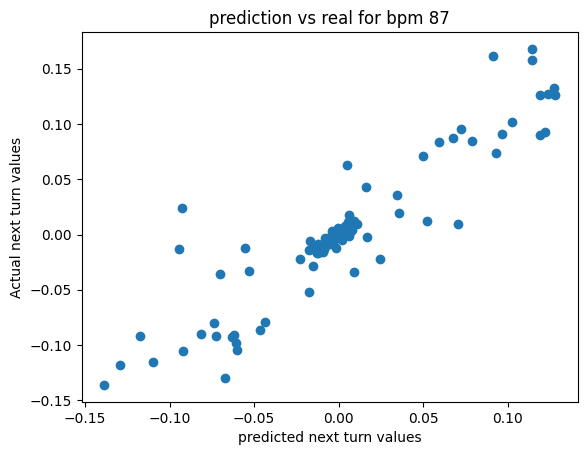


determinant: 0.8142100403951376
determinant after: 1.0

Matrix Elements from bpm 86:  1.455204556090527 19.848006060853738 -0.14599677977310194 -1.3041087329330756
y-intercepts from bpm 86:  0.022049928748031376 0.0008954897369582572
Twiss parameter calculation from bpm 86:
	 -gs/b vs m21: -0.13491882415424347 -0.14599677977310194
	 c - as vs m22: -1.1530129097756243 -1.3041087329330756

tune: 0.2258598987653968
determinant: 0.8142100403951378
determinant after: 1.0

Matrix Elements from bpm 87:  -0.9760549980183764 14.384982982454204 -0.14599677977310188 1.1271508211758285
y-intercepts from bpm 87:  0.03696236710434193 0.0008954897369582568
Twiss parameter calculation from bpm 87:
	 -gs/b vs m21: -0.15624898747834662 -0.14599677977310188
	 c - as vs m22: 1.2782466443332807 1.1271508211758285

tune: 0.22585989876539667


In [296]:
initial_turn = 35
interval_turn = 50
bpm1, bpm2 = 86, 87
L = L_86_87
Twiss1, Twiss2, X_data1, Y_data1, X_data2, Y_data2 = LR_calculation(initial_turn, interval_turn, bpm1, bpm2, s_86, s_87, L)

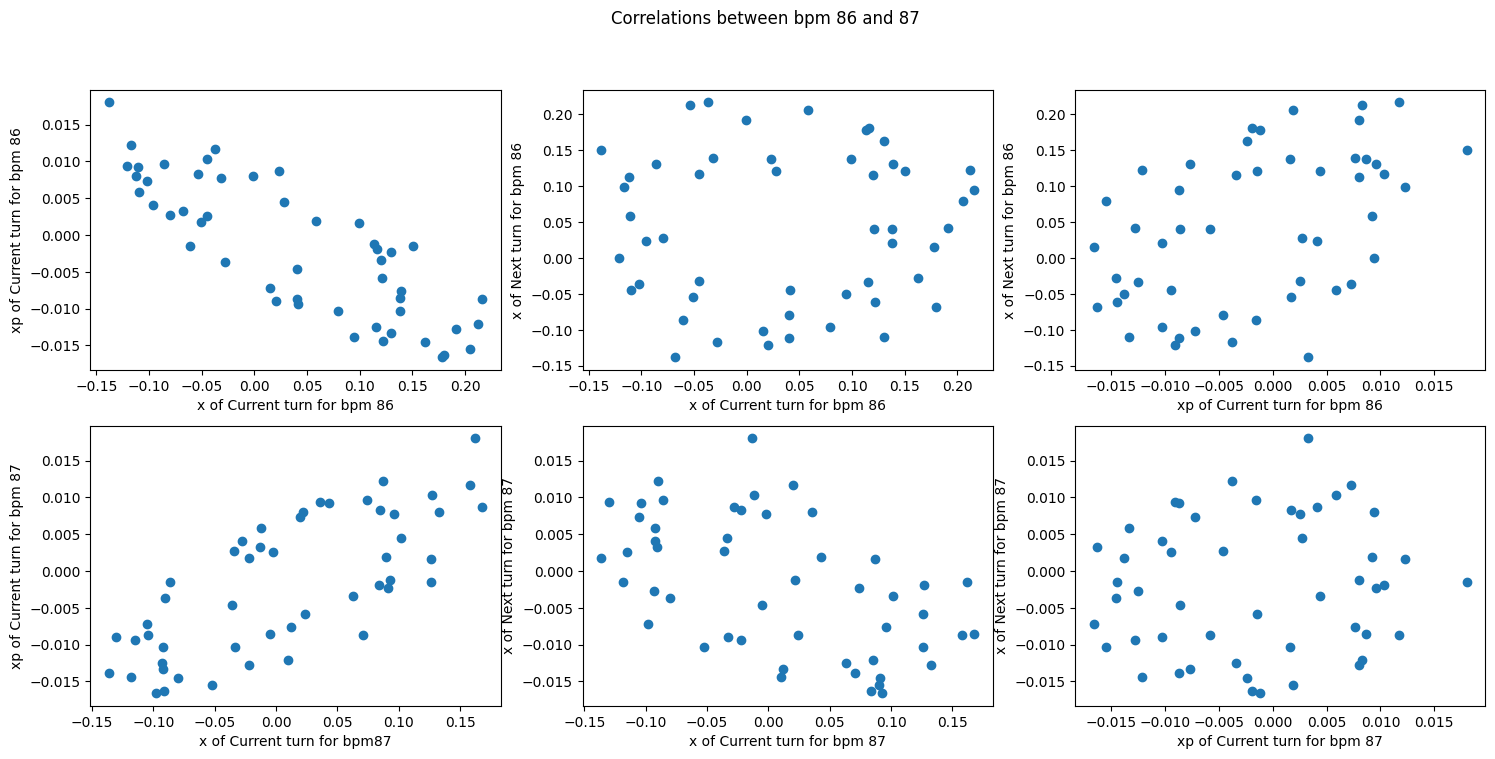

In [297]:
plot_correlations(X_data1, Y_data1, X_data2, Y_data2, bpm1, bpm2)

In [298]:
phi1, beta1, alpha1, bs1, ss1 = Twiss1
phi2, beta2, alpha2, bs2, ss2 = Twiss2
b1_m = 19.15235045
bs_m = 4.987128909
b2_m = 18.63167495

print("phi, beta, alpha from LR at bpm 86:", phi1, beta1, alpha1)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 86", bs1, ss1, ss1 - sIP12)
print("phi, beta, alpha from MADx at bpm 86:", 14.42075716, b1_m, 1.68561401)
print("beta beat at bpm 86:", (b1_m - beta1)/b1_m)
print("beta beat at b* from bpm 86:", (bs_m - bs1)/bs_m)
print()
print("phi, beta, alpha from LR at bpm 87:", phi2, beta2, alpha2)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 87", bs2, ss2, ss2 - sIP12)
print("phi, beta, alpha from MADx at bpm 87:", 14.74900606, b2_m, -1.654347369)
print("beta beat at bpm 87:", (b2_m - beta2)/b2_m)
print("beta beat at b* from bpm 87:", (bs_m - bs2)/bs_m)
print()
bs_2, ss_2 = L_86_87/(alpha1 - alpha2), s_86 + L_86_87*alpha1/(alpha1 - alpha2)
print("beta*, s*, and delta s* calculated from both bpms:", bs_2, ss_2, ss_2 - sIP12)
print("beta beat at b* from both bpms:", (bs_m - bs_2)/bs_m)

phi, beta, alpha from LR at bpm 86: 1.41911959740381 20.078525182611997 1.3192549395027082
beta*, s*, and delta s* calculated from beta and alpha at bpm 86 7.3267694631602565 1918.7328968048716 1.3394740368316889
phi, beta, alpha from MADx at bpm 86: 14.42075716 19.15235045 1.68561401
beta beat at bpm 86: -0.04835828035989167
beta beat at b* from bpm 86: -0.46913576866602236

phi, beta, alpha from LR at bpm 87: 1.419119597403809 14.55205334879005 -1.1402417995133967
beta*, s*, and delta s* calculated from beta and alpha at bpm 87 6.3265633702477 1918.5060379979732 1.1126152299332261
phi, beta, alpha from MADx at bpm 87: 14.74900606 18.63167495 -1.654347369
beta beat at bpm 87: 0.21896161306796255
beta beat at b* from bpm 87: -0.2685782713237061

beta*, s*, and delta s* calculated from both bpms: 6.7708282494661 1917.9994686126327 0.6060458445926997
beta beat at b* from both bpms: -0.3576605644275918


## Averages Calculation

$\mathcal{A}^2 = \sqrt{\langle x_{27}^2 \rangle \langle x_{28}^2 \rangle - \langle x_{27} x_{28} \rangle^2}$\
$\beta_1 = \frac{L\langle x_{27}^2 \rangle}{\mathcal{A}^2}$\
$\beta_2 = \frac{L\langle x_{28}^2 \rangle}{\mathcal{A}^2}$

$\alpha_1 = \frac{\langle x_{27}^2 \rangle  - \langle x_{27} x_{28} \rangle}{\mathcal{A}^2}$\
$\alpha_2 = \frac{\langle x_{28}^2 \rangle - \langle x_{27} x_{28} \rangle}{\mathcal{A}^2}$

$\beta^* = \frac{L}{\alpha_1 - \alpha_2}$\
$s^* = \frac{L\alpha_1}{\alpha_1 - \alpha_2}$

In [233]:
def average_calculation(initial_turn, interval_turn, bpm1, bpm2, s1, s2, L, plot_data = True):
    x_data1 = BPMx[bpm1, initial_turn: initial_turn + interval_turn] - np.mean(BPMx[bpm1])
    x_data2 = BPMx[bpm2, initial_turn: initial_turn + interval_turn] - np.mean(BPMx[bpm2])

    if plot_data:
        x_turns = np.linspace(initial_turn, initial_turn + interval_turn, interval_turn)
        plt.plot(x_turns, x_data1, label = str(bpm1))
        plt.plot(x_turns, x_data2, label = str(bpm2))
        plt.xlabel("# Turns")
        plt.ylabel("Scaled position")
        plt.legend()
        plt.show()

    A2 = np.sqrt(np.mean(x_data1**2)*np.mean(x_data2**2) - np.mean(x_data1*x_data2)**2)

    b1, b2 = L*np.mean(x_data1**2)/A2, L*np.mean(x_data2**2)/A2
    a1 = (np.mean(x_data1**2) - np.mean(x_data1*x_data2))/A2
    a2 = -(np.mean(x_data2**2) - np.mean(x_data1*x_data2))/A2
    bs, ss = L/(a1 - a2), L*a1/(a1 - a2)

    def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
        denom = (x1-x2) * (x1-x3) * (x2-x3)
        A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
        B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
        C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
        return A,B,C
    
    A, B, C = calc_parabola_vertex(s1, b1, s1 + ss, bs, s2, b2)
    s_space = np.linspace(s1, s2, 1000)
    Betatron = A*s_space**2 + B*s_space + C
    if plot_data:
        plt.plot([s1, s1 + ss, s2], [b1, bs, b2], 'o')
        plt.plot(s_space, Betatron)
        plt.xlabel("s")
        plt.ylabel(r"$\beta$")
        plt.title("Betatron function")
        plt.show()
    
    return b1, b2, a1, a2, bs, ss

def plot_beta(initial_turn, min_turns, max_turns, bpm1, bpm2, s1, s2, L):
    Interval_turns = np.linspace(min_turns, max_turns, max_turns - min_turns + 1)
    # print(x_turns)
    B1 = np.zeros(max_turns - min_turns + 1)
    B2 = np.zeros(max_turns - min_turns + 1)
    for i in Interval_turns:
        i = int(i)
        b1, b2, _, _, _, _ = average_calculation(initial_turn, i, bpm1, bpm2, s_167, s_0, L, plot_data = False)
        B1[i - min_turns] = b1
        B2[i - min_turns] = b2

    plt.plot(Interval_turns, B1, label = "Bpm %d"%bpm1)
    plt.plot(Interval_turns, B2, label = "Bpm %d"%bpm2)
    plt.xlabel("interval turns")
    plt.ylabel("beta")
    plt.legend()
    plt.show()

### IP6 (BPM 167-0)

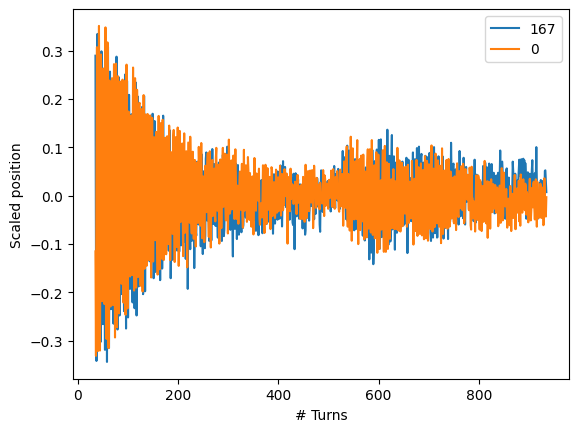

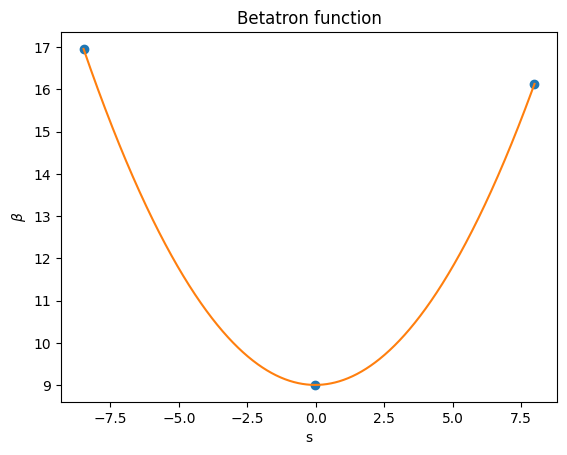

In [234]:
initial_turn = 35
interval_turn = 900
bpm1, bpm2 = 167, 0
L = L_167_0
b1, b2, a1, a2, bs, ss = average_calculation(initial_turn, interval_turn, bpm1, bpm2, s_167, s_0, L)

In [235]:
b1_m = 100.3380643
bs_m = 0.6958493096
b2_m = 92.50155563
print("beta and alpha at bpm 167:", b1, a1)
print("beta and alpha at bpm 0:", b2, a2)
print("beta*, s*, and delta s* from both bpms:", bs, ss, s_167 + ss - sIP6)
print("Beta beat at b1, b2, b*:", (b1_m - b1)/b1_m, (b2_m - b2)/b2_m, (bs_m - bs)/bs_m)
print()

bs1 = b1/(1 + a1**2)
bs2 = b2/(1 + a2**2)
ss1 = s_167 + bs1*a1
ss2 = s_0 + bs2*a2
print("beta*, s*, and delta s* from bpm 167:", bs1, ss1, ss1 - sIP6)
print("beta beat of beta* from bpm 167:", (bs_m - bs1)/bs_m)
print("beta*, s*, and delta s* from bpm 0:", bs2, ss2, ss2 - sIP6)
print("beta beat of beta* from bpm 0:", (bs_m - bs2)/bs_m)

beta and alpha at bpm 167: 16.959709127257916 0.9396993374909679
beta and alpha at bpm 0: 16.13171374832369 -0.889439485843629
beta*, s*, and delta s* from both bpms: 9.006582737097476 8.463479831108087 -0.017720168892084942
Beta beat at b1, b2, b*: 0.8309743241951508 0.8256060275045594 -11.943294780697267

beta*, s*, and delta s* from bpm 167: 9.006582737097478 -0.017720168892083166 -0.017720168892083166
beta beat of beta* from bpm 167: -11.943294780697268
beta*, s*, and delta s* from bpm 0: 9.006582737097478 -0.01772016889208583 -0.01772016889208583
beta beat of beta* from bpm 0: -11.943294780697268


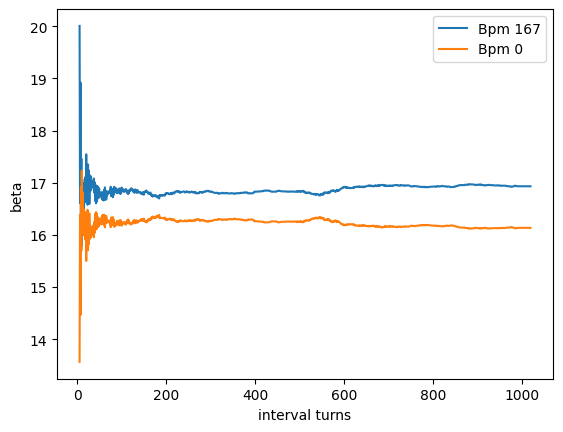

In [236]:
plot_beta(initial_turn, 5, 1019, bpm1, bpm2, s_167, s_0, L)

### IP8 (BPM 27-28)

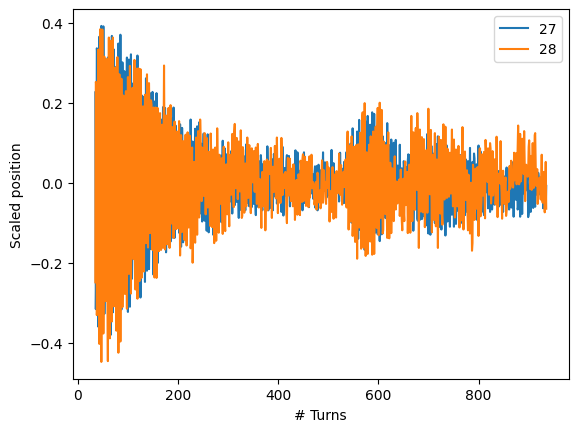

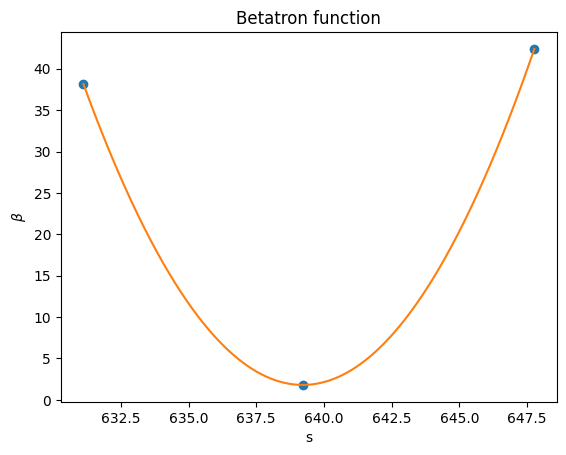

In [226]:
initial_turn = 35
interval_turn = 900
bpm1, bpm2 = 27, 28
L = L_27_28
b1, b2, a1, a2, bs, ss = average_calculation(initial_turn, interval_turn, bpm1, bpm2, s_27, s_28, L)

In [227]:
b1_m = 99.54348468
bs_m = 0.7011039589
b2_m = 99.62958574
print("beta and alpha at bpm 27:", b1, a1)
print("beta and alpha at bpm 28:", b2, a2)
print("beta*, s*, and delta s* from both bpms:", bs, s_27 + ss, s_27 + ss - sIP8)
print("Beta beat at b1, b2, b*:", (b1_m - b1)/b1_m, (b2_m - b2)/b2_m, (bs_m - bs)/bs_m)
print()

bs1 = b1/(1 + a1**2)
bs2 = b2/(1 + a2**2)
ss1 = s_27 + bs1*a1
ss2 = s_28 + bs2*a2
print("beta*, s*, and delta s* from bpm 27:", bs1, ss1, ss1 - sIP8)
print("beta beat of beta* from bpm 27:", (bs_m - bs1)/bs_m)
print("beta*, s*, and delta s* from bpm 28:", bs2, ss2, ss2 - sIP8)
print("beta beat of beta* from bpm 28:", (bs_m - bs2)/bs_m)


beta and alpha at bpm 27: 38.148161535918376 4.489076178333839
beta and alpha at bpm 28: 42.39711700633547 -4.744228104638003
beta*, s*, and delta s* from both bpms: 1.8035416671701148 639.2149489347258 -0.23007901489211235
Beta beat at b1, b2, b*: 0.6167688758480544 0.5744525414671721 -1.5724311555732604

beta*, s*, and delta s* from bpm 27: 1.8035416671701148 639.2149489347258 -0.23007901489211235
beta beat of beta* from bpm 27: -1.5724311555732604
beta*, s*, and delta s* from bpm 28: 1.8035416671701143 639.2149489347258 -0.23007901489211235
beta beat of beta* from bpm 28: -1.5724311555732597


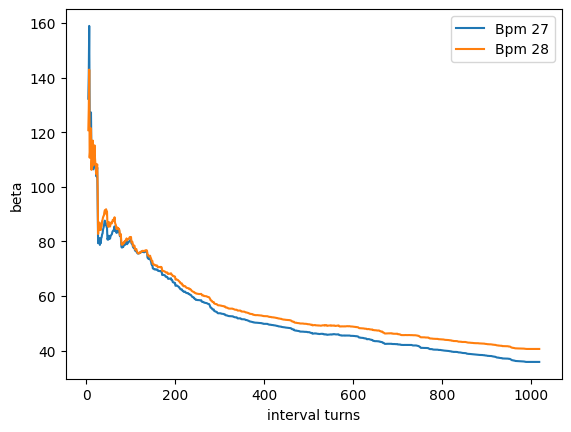

In [220]:
plot_beta(initial_turn, 5, 1019, bpm1, bpm2, s_27, s_28, L)

?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????
?????????????????????

### IP10 (BPM 57-60)

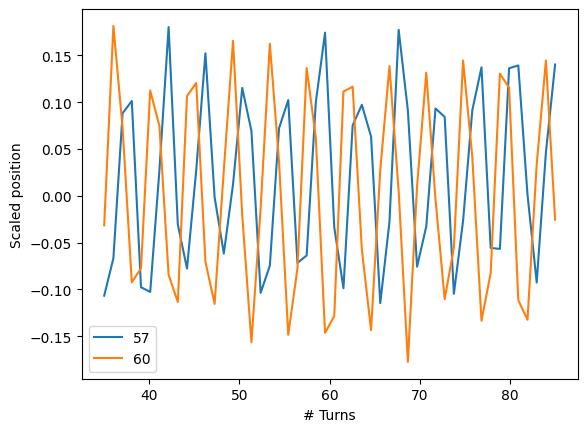

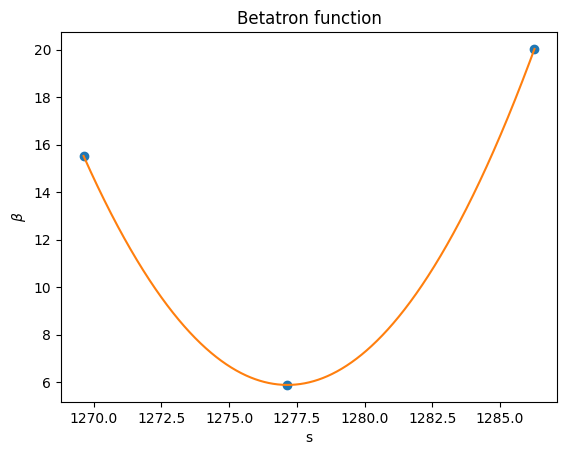

In [211]:
initial_turn = 35
interval_turn = 50
bpm1, bpm2 = 57, 60
L = L_57_60
b1, b2, a1, a2, bs, ss = average_calculation(initial_turn, interval_turn, bpm1, bpm2, s_57, s_60, L)

In [212]:
b1_m = 18.85271553
bs_m = 5.059938613
b2_m = 18.67088168
print("beta and alpha at bpm 57:", b1, a1)
print("beta and alpha at bpm 60:", b2, a2)
print("beta*, s*, and delta s* from both bpms:", bs, s_57 + ss, s_57 + ss - sIP10)
print("Beta beat at b1, b2, b*:", (b1_m - b1)/b1_m, (b2_m - b2)/b2_m, (bs_m - bs)/bs_m)
print()

bs1 = b1/(1 + a1**2)
bs2 = b2/(1 + a2**2)
ss1 = s_57 + bs1*a1
ss2 = s_60 + bs2*a2
print("beta*, s*, and delta s* from bpm 57:", bs1, ss1, ss1 - sIP10)
print("beta beat of beta* from bpm 57:", (bs_m - bs1)/bs_m)
print("beta*, s*, and delta s* from bpm 60:", bs2, ss2, ss2 - sIP10)
print("beta beat of beta* from bpm 60:", (bs_m - bs2)/bs_m)

beta and alpha at bpm 57: 15.52057362513482 1.2795485823055448
beta and alpha at bpm 60: 20.025451390770655 -1.5500677810206978
beta*, s*, and delta s* from both bpms: 5.885147617829238 1277.152402291052 -0.7959915273879687
Beta beat at b1, b2, b*: 0.17674599182079642 -0.07254985243796234 -0.1630867621020363

beta*, s*, and delta s* from bpm 57: 5.885147617829238 1277.152402291052 -0.7959915273879687
beta beat of beta* from bpm 57: -0.1630867621020363
beta*, s*, and delta s* from bpm 60: 5.885147617829239 1277.152402291052 -0.7959915273879687
beta beat of beta* from bpm 60: -0.16308676210203646


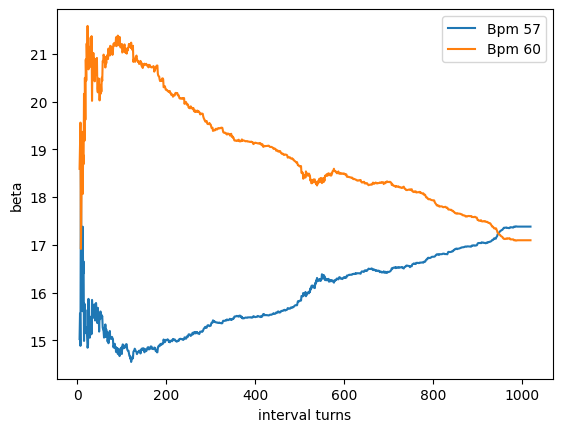

In [214]:
plot_beta(initial_turn, 5, 1019, bpm1, bpm2, s_57, s_60, L)

### IP12 (BPM 86-87)

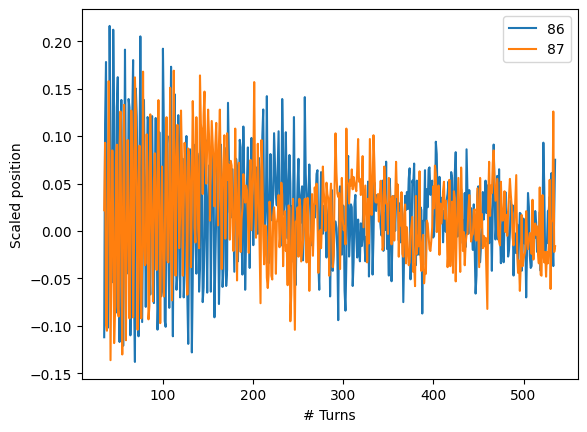

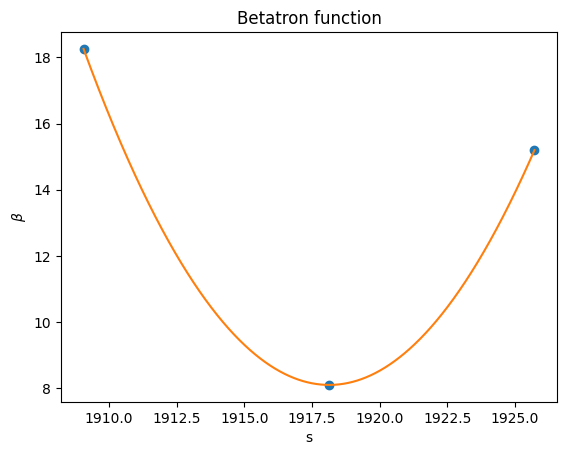

In [215]:
initial_turn = 35
interval_turn = 500
bpm1, bpm2 = 86, 87
L = L_86_87
b1, b2, a1, a2, bs, ss = average_calculation(initial_turn, interval_turn, bpm1, bpm2, s_86, s_87, L)

In [216]:
b1_m = 19.15235045
bs_m = 4.987128909
b2_m = 18.63167495
print("beta and alpha at bpm 86:", b1, a1)
print("beta and alpha at bpm 87:", b2, a2)
print("beta*, s*, and delta s* from both bpms:", bs, s_86 + ss, s_86 + ss - sIP12)
print("Beta beat at b1, b2, b*:", (b1_m - b1)/b1_m, (b2_m - b2)/b2_m, (bs_m - bs)/bs_m)
print()

bs1 = b1/(1 + a1**2)
bs2 = b2/(1 + a2**2)
ss1 = s_86 + bs1*a1
ss2 = s_87 + bs2*a2
print("beta*, s*, and delta s* from bpm 86:", bs1, ss1, ss1 - sIP12)
print("beta beat of beta* from bpm 86:", (bs_m - bs1)/bs_m)
print("beta*, s*, and delta s* from bpm 87:", bs2, ss2, ss2 - sIP12)
print("beta beat of beta* from bpm 87:", (bs_m - bs2)/bs_m)

beta and alpha at bpm 86: 18.258122673200354 1.1202863101305591
beta and alpha at bpm 87: 15.197345783631086 -0.93648710665768
beta*, s*, and delta s* from both bpms: 8.096579751601551 1918.1375074545995 0.7440846865595176
Beta beat at b1, b2, b*: 0.046690236748442845 0.18432745180373142 -0.623495181163273

beta*, s*, and delta s* from bpm 86: 8.096579751601551 1918.1375074545995 0.7440846865595176
beta beat of beta* from bpm 86: -0.623495181163273
beta*, s*, and delta s* from bpm 87: 8.09657975160155 1918.1375074545995 0.7440846865595176
beta beat of beta* from bpm 87: -0.6234951811632726


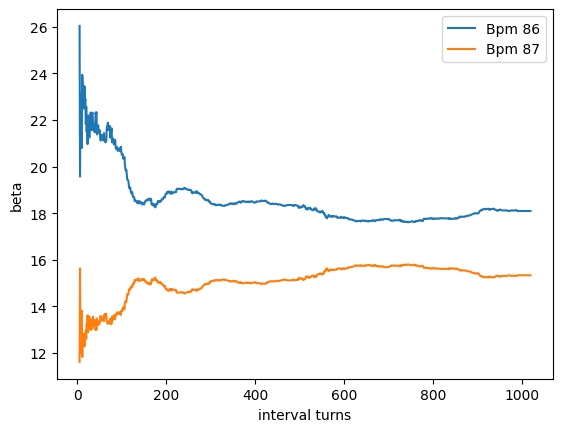

In [217]:
plot_beta(initial_turn, 5, 1019, bpm1, bpm2, s_86, s_87, L)

## Fitting Normalized Phase Space

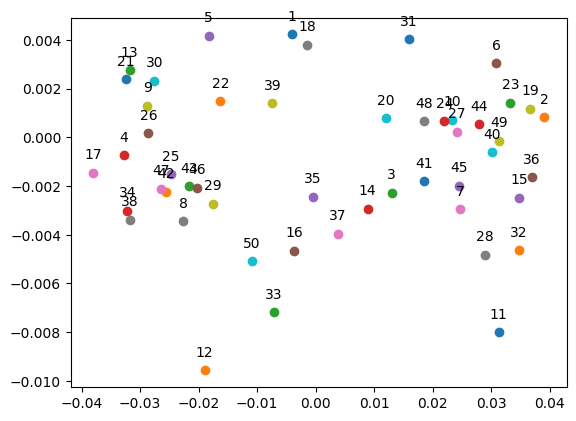

In [479]:
initial_turn = 50
interval_turn = 50
x_data27 = (BPMx[27, initial_turn: initial_turn + interval_turn] - np.mean(BPMx[27]))
# print(x_data27)
x_data28 = (BPMx[28, initial_turn: initial_turn + interval_turn] - np.mean(BPMx[28]))
# print(x_data28)
xp_data27 = (x_data28 - x_data27)/L_27_28
# print(xp_data27)

beta = 10
alpha = 1.2
x_data27_norm = x_data27/beta
xp_data27_norm = xp_data27 + alpha/beta*x_data27
turn_label = np.linspace(1, interval_turn, interval_turn)
for i in range(interval_turn):
    plt.plot(x_data27_norm[i], xp_data27_norm[i], 'o')#, alpha = (interval_turn - i)/interval_turn)
for x, y, text in zip(x_data27_norm, xp_data27_norm, turn_label):
    plt.annotate(str(int(text)), # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()


In [117]:
phi = 2*np.pi*nu_x
m_mm = 10**3 # meters to millimeters

N_init = 35
N_interval = 250

# def x_final(x, xp, b0, b, a0):
#     return (np.sqrt(b/b0)*(np.cos(phi) + a0*np.sin(phi))*x 
#             + np.sqrt(b*b0)*np.sin(phi)*xp)
def x_final2(x, xp, b0, b, a0):
    return (  (b/b0) * ((np.cos(phi) + a0*np.sin(phi))*x)**2
            + (b*b0) * (np.sin(phi)*xp)**2
            + 2*b * (np.cos(phi) + a0*np.sin(phi))*x*np.sin(phi)*xp )

# def xp_final(x, xp, b0, b, a0, a):
#     return (1/np.sqrt(b*b0)*((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi))*x 
#             + np.sqrt(b0/b)*(np.cos(phi) - a*np.sin(phi))*xp)
def xp_final2(x, xp, b0, b, a0, a):
    return (  (1/(b*b0) * (((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi))*x)**2
            + (b0/b) * ((np.cos(phi) - a*np.sin(phi))*xp)**2
            + 2/b * ((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi))*x*(np.cos(phi) - a*np.sin(phi))*xp) )

def func(x, args):
    xs, xps, bs, ss, b0, b, a0, a = x
    x_27, x_28, dx = args
    dx_28 = dx_27 = dx
    System = [
            #Phase Transfer from 27 to 28
            x_28**2 - x_final2(x_27, dx_27, b0, b, a0),
            dx_28**2 - xp_final2(x_27, dx_27, b0, b, a0, a),
            
            #Phase Transfer from * to 28
            x_28**2 - x_final2(xs, xps, bs, b, 0),
            dx_28**2 - xp_final2(xs, xps, bs, b, 0, a),
            
            #Phase Transfer from 27 to *
            xs**2 - x_final2(x_27, dx_27, b0, bs, a0),
            xps**2 - xp_final2(x_27, dx_27, b0, bs, a0, 0),
            
            #Twiss Transfer from 27 to *
            bs + (ss - s_27)**2/bs - b0,
            #Twiss Transfer from * to 28
            bs + (s_28 - ss)**2/bs - b]
    
    #print(a0, a)
    #Determinant
#     print((np.cos(phi) + a0*np.sin(phi))*(np.cos(phi) - a*np.sin(phi))
#           - np.sin(phi)*((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi)))
    Sys_vals.append([xs, xps, bs, ss, b0, b, a0, a])
    return System


def SolveSystem(f, Initial):
    # X_star, Xp_star, beta_star, s_star, beta_27, beta_28, alpha_27, alpha_28
    Unknowns = np.zeros([N_turns, 8])
    Error = np.zeros([N_turns, 8])
    
    i = 0
    for turn in range(N_turns):
        x_27, x_28 = Pos_xbpms[turn, 27: 29]/m_mm
        dx = (x_28 - x_27)/L_27_28
        Args = [x_27, x_28, dx]
        Data = optimize.fsolve(f, Initial, args = Args, full_output = True)
        infodict = Data[1]
        
        Unknowns[i] = Data[0]
        Error[i] = infodict['fvec']

        i += 1
    return Unknowns, Error
        

In [118]:
Sys_vals = []
x_27, x_28 = Pos_xbpms[N_init, 27: 29]/m_mm
dx = (x_28 - x_27)/L_27_28
print("x_27, x_28, dx:")
print(x_27, x_28, dx)
print()

init_vals = [0, dx, 0.5, sIP8, 99.54348468, 99.62958574, 11.87358459, -11.87875497]
Args = [x_27, x_28, dx]

init_res = func(init_vals, Args)
init_err = np.sqrt(np.sum(np.array(init_res)**2))
print("initial function result:", init_res, '\n')
print("initial error:", init_err, '\n')
print("initial results:", optimize.fsolve(func, init_vals, args = Args, full_output = True))


x_27, x_28, dx:
0.0111800003 -0.00784100008 -0.0011422206989410515

initial function result: [-0.0003398021877100824, -3.96166343755902e-06, -2.922100880071166e-06, 3.7434243410465933e-07, -2.0138770375491754e-06, -4.394495456273774e-07, 39.61155660046421, 39.526091697101506] 

initial error: 55.958800391671645 

initial results: (array([ 9.02826407e-04, -1.15574698e-03,  4.51625552e-01,  6.39617320e+02,
        1.60376844e+02,  1.47671831e+02,  1.70237949e+01, -2.04426595e+01]), {'nfev': 307, 'fjac': array([[ 0.00000000e+00,  0.00000000e+00, -9.97712543e-01,
        -1.03161314e-02, -6.68076265e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.15185639e-15,  0.00000000e+00, -6.20660158e-02,
        -1.56871420e-01,  9.51124175e-01,  2.58654154e-01,
         0.00000000e+00,  0.00000000e+00],
       [-2.47095665e-17, -1.53714837e-18, -9.38651633e-12,
         4.62636059e-10,  6.87411147e-11,  2.55571216e-11,
        -7.35809551e-01, -6.77188530e-01],
       [ 1

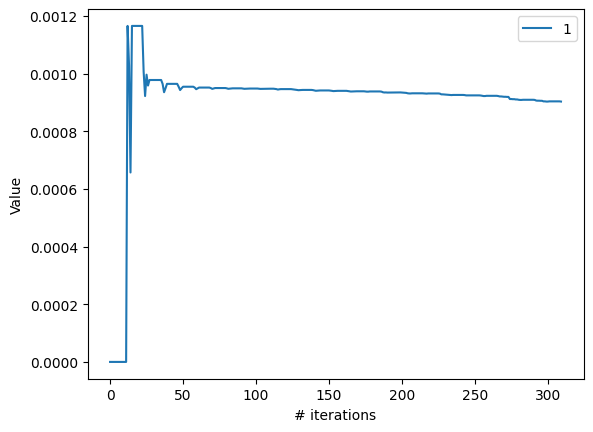

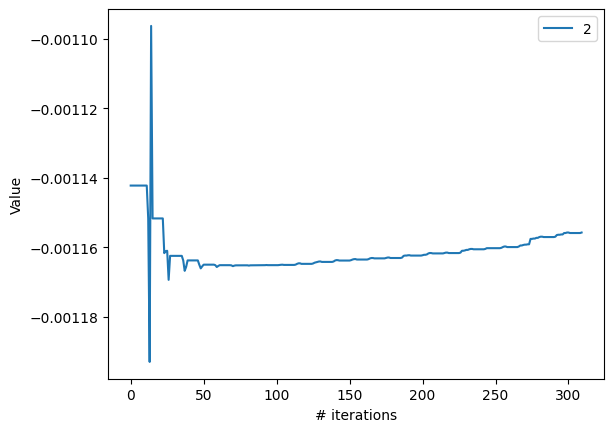

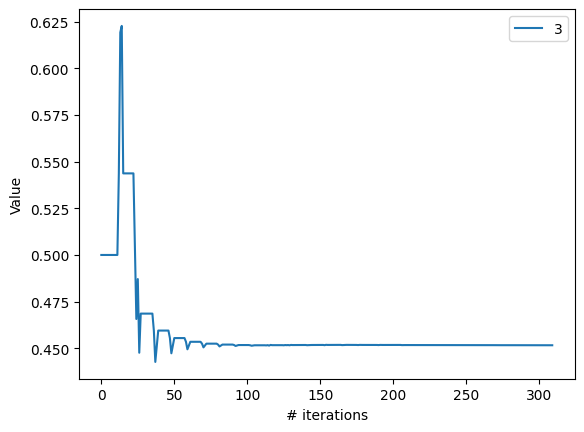

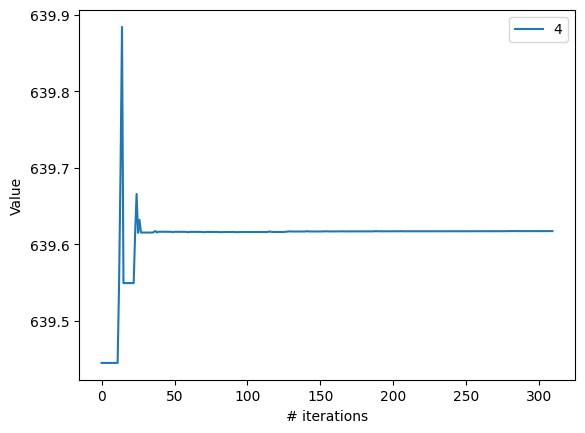

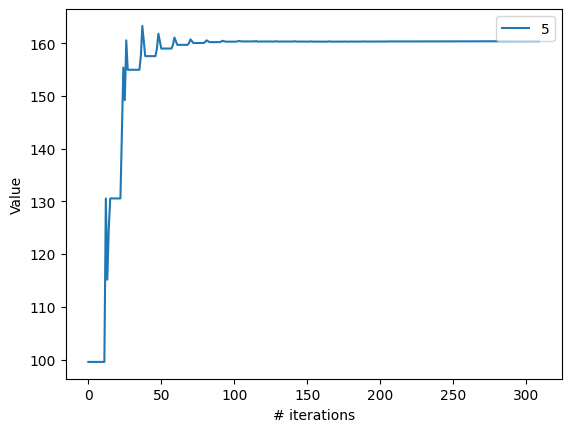

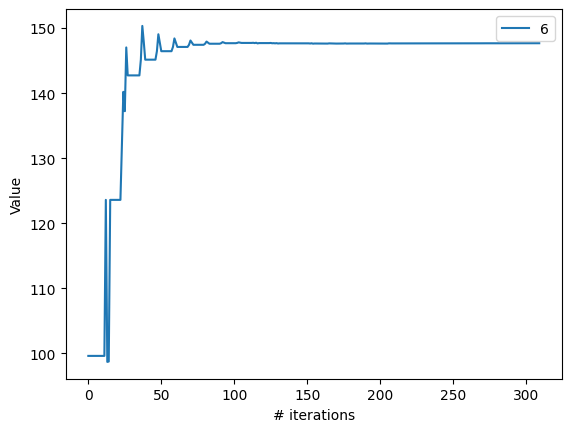

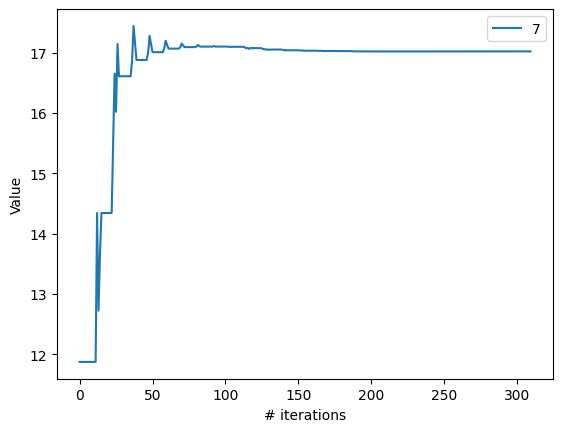

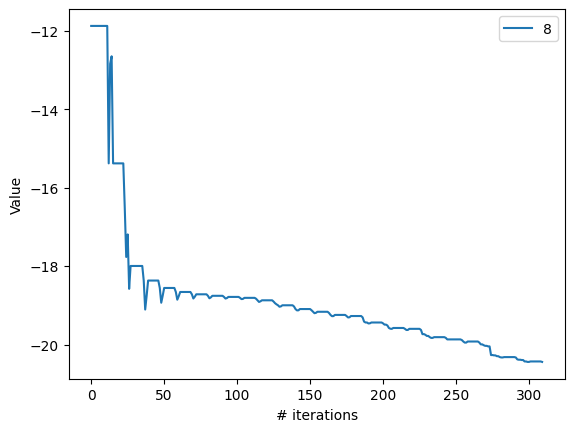

In [119]:
for i in range(8):
    plt.plot((np.array(Sys_vals).T[i]), label = str(i + 1))
    plt.ylabel("Value")
    plt.xlabel("# iterations")
    #plt.yscale("log")
    plt.legend()
    plt.show()

- Fourth and sixth equations increase in error
- Some converge on $Err_i \approx 10^{-6} $, while others oscillate in a periodic fashion, which might be why the program is saying no improvement

- All variables converge for any choice of $\beta^*$

In [85]:
N_beta_star = 199
Beta_star = np.linspace(.1, 1, N_beta_star)

# Mean of data for every beta* guess
Data_mean = np.zeros([N_beta_star, 8])

# Standard deviation of data for every beta* guess
Data_stddev = np.zeros([N_beta_star, 8])

# L2 Error for every beta* guess
Error_mean = np.zeros(N_beta_star)

for i, bs in enumerate(Beta_star):
    #Initial guess from MADx store twiss values
    initial = [0, dx, bs, sIP8, 99.54348468, 99.62958574, 11.87358459, -11.87875497]
    
    Unknown_Data, Error = SolveSystem(func, initial)
    Data_mean[i] = np.mean(Unknown_Data.T, axis = 1)
    Data_stddev[i] = np.std(Unknown_Data.T, axis = 1)
    Error_mean[i] = np.sqrt(np.sum(np.mean(Error.T, axis = 1)**2))
    
print('done')

done


0.8045454545454545
[ 4.35118999e-04 -1.08054027e-03  5.94985327e-01  6.40251248e+02
  1.41509418e+02  9.58897586e+01  1.51363635e+01 -1.40759041e+01]
[2.91327231e-04 1.74013532e-05 3.48153958e-02 1.98893603e-01
 1.26683789e+01 5.26889863e+00 1.35491244e+00 6.97280190e-01]
0.806220008234277


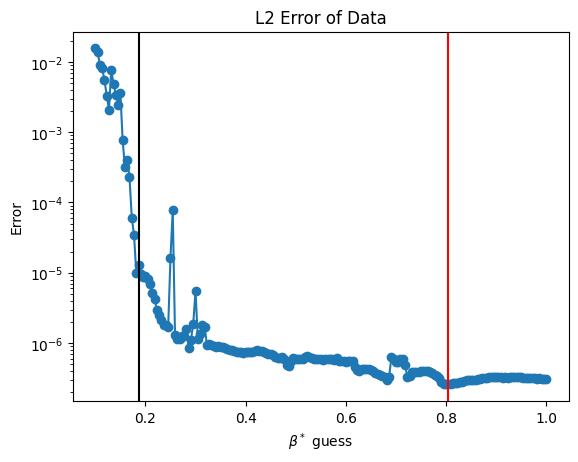

In [138]:
Min_err_index = np.argmin(Error_mean)
print(Beta_star[Min_err_index])
print(Data_mean[Min_err_index])
print(Data_stddev[Min_err_index])
print(Data_mean[Min_err_index][3] - sIP8)

plt.plot(Beta_star, Error_mean, '-o')
plt.title("L2 Error of Data")
plt.xlabel(r"$\beta^*$ guess")
plt.ylabel("Error")
plt.yscale('log')
# plt.xlim(.4, 1)
# plt.ylim(1E-7, 1E-6)
plt.axvline(x = Beta_star[Min_diff_index], color = "k") #comment out
plt.axvline(x = Beta_star[Min_err_index], color = "r")
plt.show()

0.18636363636363637
[ 1.83442271e-03 -1.13885628e-03  4.37495313e-01  6.39538038e+02
  1.64785377e+02  1.59956914e+02  1.58679739e+01 -1.39804062e+01]
[5.44634239e-04 6.04884135e-04 5.54713996e-02 6.38599644e-01
 2.63451193e+01 3.61616286e+01 2.64916687e+00 5.42338033e+00]
0.09300986294772429


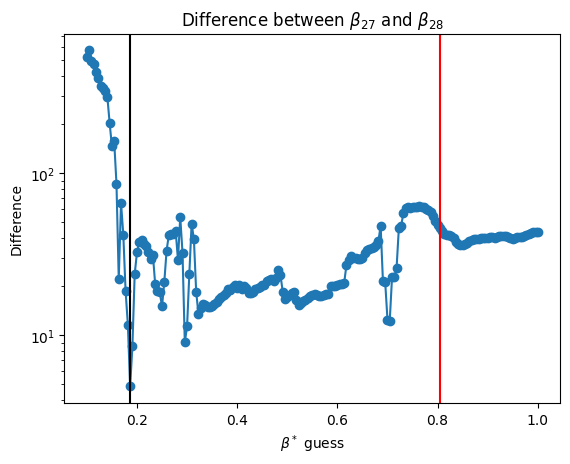

In [104]:
Beta_diff = abs(Data_mean.T[4] - Data_mean.T[5])#*(Data_mean.T[4]/100)
Min_diff_index = np.argmin(Beta_diff)
print(Beta_star[Min_diff_index])
print(Data_mean[Min_diff_index])
print(Data_stddev[Min_diff_index])
print(Data_mean[Min_diff_index][3] - sIP8)

plt.title(r"Difference between $\beta_{27}$ and $\beta_{28}$")
plt.xlabel(r"$\beta^*$ guess")
plt.ylabel("Difference")
plt.plot(Beta_star, Beta_diff, '-o')
plt.yscale("log")
plt.axvline(x = Beta_star[Min_diff_index], color = "k")
plt.axvline(x = Beta_star[Min_err_index], color = "r")
plt.show()

0.6121630382835905


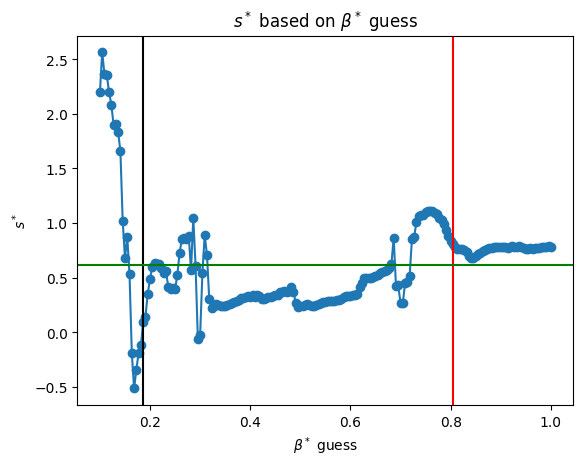

In [139]:
S_star = Data_mean.T[3] - sIP8
S_star_final_avg = np.mean(S_star)
print(S_star_final_avg)

plt.title(r"$s^*$ based on $\beta^*$ guess")
plt.xlabel(r"$\beta^*$ guess")
plt.ylabel("$s^*$")
plt.plot(Beta_star, S_star, '-o')
plt.axvline(x = Beta_star[Min_diff_index], color = "k")
plt.axvline(x = Beta_star[Min_err_index], color = "r")
plt.axhline(y = S_star_final_avg, color = 'g')
plt.show()

0.5462080491852267


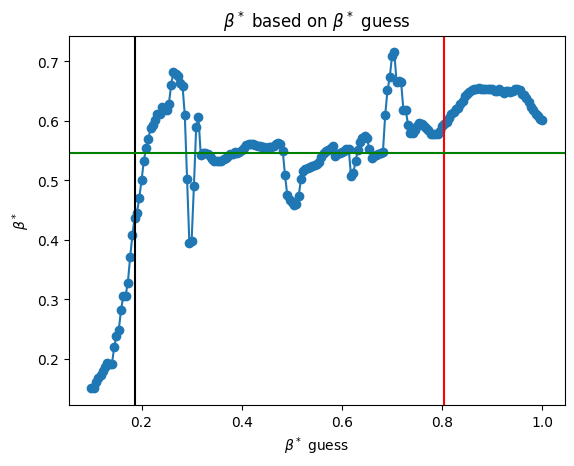

In [110]:
Beta_star_final = Data_mean.T[2]
Beta_star_final_avg = np.mean(Beta_star_final)
print(Beta_star_final_avg)

plt.title(r"$\beta^*$ based on $\beta^*$ guess")
plt.xlabel(r"$\beta^*$ guess")
plt.ylabel(r"$\beta^*$")
plt.plot(Beta_star, Beta_star_final, '-o')
#plt.plot(Beta_star, Beta_star)
plt.axvline(x = Beta_star[Min_diff_index], color = "k")
plt.axvline(x = Beta_star[Min_err_index], color = "r")
plt.axhline(y = Beta_star_final_avg, color = "g")
plt.show()

In [137]:
def func2(x, args):
    b0, b, a0, a = x
    x1_27, x1_28, xp1, x2_27, x2_28, xp2 = args
    xp1_27 = xp1_27 = xp1
    xp2_27 = xp2_28 = xp2
    System = [
            #Phase Transfer from 27 to 28 for one turn
            x1_28**2 - x_final2(x1_27, xp1, b0, b, a0),
            xp1**2 - xp_final2(x1_27, xp1, b0, b, a0, a),
        
            #Phase Transfer from 27 to 28 for another turn
            x2_28**2 - x_final2(x2_27, xp2, b0, b, a0),
            xp2**2 - xp_final2(x2_27, xp2, b0, b, a0, a),
    ]
    
#     print((np.cos(phi) + a0*np.sin(phi))*(np.cos(phi) - a*np.sin(phi))
#           - np.sin(phi)*((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi)))
    print(b0, b, a0, a, System)
    return System
    
    
initial2 = [99.54348468, 99.62958574, 11.87358459, -11.87875497]

x1_27, x1_28 = Pos_xbpms[35, 27: 29]/m_mm
xp1 = (x1_28 - x1_27)/L_27_28

x2_27, x2_28 = Pos_xbpms[36, 27: 29]/m_mm
xp2 = (x2_28 - x2_27)/L_27_28

Args2 = [x1_27, x1_28, xp1, x2_27, x2_28, xp2]
print(optimize.fsolve(func2, initial2, args = Args2, full_output = True))

iterations = 0
Max_iterations = 100000
Final = np.zeros(4)
# for i in range(N_turns):
#     for j in range(N_turns):
#         if iterations > Max_iterations: break
#         x1_27, x1_28 = Pos_xbpms[i, 27: 29]/m_mm
#         xp1 = (x1_28 - x1_27)/L_27_28
            
#         x2_27, x2_28 = Pos_xbpms[j, 27: 29]/m_mm
#         xp2 = (x2_28 - x2_27)/L_27_28
        
#         Args2 = [x1_27, x1_28, xp1, x2_27, x2_28, xp2]
#         Final += optimize.fsolve(func2, initial2, args = Args2)#, full_output = True)
        
#         iterations += 1
        

# print(Final/Max_iterations)     


99.54348468 99.62958574 11.87358459 -11.87875497 [-0.0003398021877100824, -3.96166343755902e-06, -0.0003373917752565096, -3.987748618835511e-06]
99.54348468 99.62958574 11.87358459 -11.87875497 [-0.0003398021877100824, -3.96166343755902e-06, -0.0003373917752565096, -3.987748618835511e-06]
99.54348468 99.62958574 11.87358459 -11.87875497 [-0.0003398021877100824, -3.96166343755902e-06, -0.0003373917752565096, -3.987748618835511e-06]
99.54348616331352 99.62958574 11.87358459 -11.87875497 [-0.0003398021141297496, -3.961662428313002e-06, -0.0003373917063346969, -3.987747671808061e-06]
99.54348468 99.6295872245965 11.87358459 -11.87875497 [-0.0003398021936896777, -3.961663359084575e-06, -0.00033739178108684926, -3.9877485420460245e-06]
99.54348468 99.62958574 11.873584766930199 -11.87875497 [-0.0003398022666346715, -3.96166452424472e-06, -0.00033739184941171586, -3.987749641678508e-06]
99.54348468 99.62958574 11.87358459 -11.878754792992757 [-0.0003398021877100824, -3.96166327421144e-06, -0.

## Averages Calculation

$\mathcal{A}^2 = \sqrt{\langle x_{27}^2 \rangle \langle x_{28}^2 \rangle - \langle x_{27} x_{28} \rangle^2}$\
$\beta_1 = \frac{L\langle x_{27} \rangle}{\mathcal{A}^2}$\
$\beta_2 = \frac{L\langle x_{28} \rangle}{\mathcal{A}^2}$

$\alpha_1 = \frac{\langle x_{27}^2 \rangle  - \langle x_{27} x_{28} \rangle}{\mathcal{A}^2}$\
$\alpha_2 = \frac{\langle x_{28}^2 \rangle - \langle x_{27} x_{28} \rangle}{\mathcal{A}^2}$

$\beta^* = \frac{L}{\alpha_1 - \alpha_2}$\
$s^* = \frac{L\alpha_1}{\alpha_1 - \alpha_2}$

This method doesn't work as well since $|x_{27}^2|$ is half of $|x_{28}^2|$, which means that $\beta_{27}$ will not be close to $\beta_{28}$.

0.00011999852130340692 5.765245213103308e-05
3289.7108737066633 1580.5186314902342
334.47412297471135 -231.83626384392502
0.029405515751794054 9.835384091700375


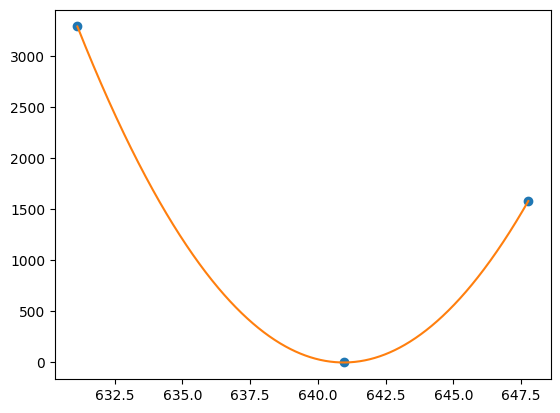

In [14]:
m_mm = 1E3
x_27 = BPMx[27]/m_mm
x_28 = BPMx[28]/m_mm

x_27_mean2 = np.mean(x_27**2)
x_28_mean2 = np.mean(x_28**2)
print(x_27_mean2, x_28_mean2)
x_27_28_mean = np.mean((x_27*x_28))
A2 = np.sqrt(x_27_mean2*x_28_mean2 - x_27_28_mean**2)

b_27, b_28 = L_27_28*x_27_mean2/A2, L_27_28*x_28_mean2/A2
a_27, a_28 = (x_27_mean2 - x_27_28_mean)/A2, -(x_28_mean2 - x_27_28_mean)/A2
bs, ss = L_27_28/(a_27 - a_28), L_27_28*a_27/(a_27 - a_28)

print(b_27, b_28)
print(a_27, a_28)
print(bs, ss)

      
def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C
A, B, C = calc_parabola_vertex(s_27, b_27, s_27 + ss, bs, s_28, b_28)
s_space = np.linspace(s_27, s_28, 1000)
Betatron = A*s_space**2 + B*s_space + C
plt.plot([s_27, s_27 + ss, s_28], [b_27, bs, b_28], 'o')
plt.plot(s_space, Betatron)
plt.show()